# Market Retail Analysis

1. Data acquired from https://www.kaggle.com/datasets/koelin/retail-purchase-history?resource=download
0. 

## Import libraries

In [ ]:
import shutil
import sys
from collections.abc import Callable
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from prophet import Prophet

In [211]:
# --- AUTO-SYNC FROM GITHUB ---
# DO NOT EDIT

COLAB_ACTIVE = 'google.colab' in sys.modules

if COLAB_ACTIVE:
    REPO_URL = 'https://github.com/Ri-Dearg/ca2-market-retail.git'
    REPO_DIR = '/content/repo'

    if not Path(REPO_DIR).exists():
        !git clone $REPO_URL $REPO_DIR
    elif not Path(Path(REPO_DIR) / '.git').exists():
        shutil.rmtree(REPO_DIR)
        !git clone $REPO_URL $REPO_DIR
    else:
        %cd $REPO_DIR
        !git pull origin main

    %cd /content/repo
else:
    print('Running locally, not in Colab')


Running locally, not in Colab


## Utilities

In [212]:
# Callable function to create plots
def multi_row_plot(
    seaborn_func: Callable,
    data: pd.DataFrame,
    grid: tuple = (4, 4),
    size: tuple = (25, 20),
    *,
    y_col: bool = False,
    y_val: str = '',
    **kwargs: dict[str, Any],
) -> None:
    """Create a plot with default values.

    Args:
        seaborn_func (Callable): seaborn plot function to run.
        data (object): _description_
        grid (tuple, optional): Rows and columns. Defaults to (2, 7).
        size (tuple, optional): Width and Height. Defaults to (32, 7).
        y_col(None, optional): x axis if doing a correlation plot.
        y_val(str, optional): Value to plot on y axis.
        **kwargs(dict, optional): keyword for the seaborn function

    """
    data_cols = data.columns

    # Structure plots to easily fit the data.
    fig_plot, axes = plt.subplots(grid[0], grid[1], figsize=(size[0], size[1]))
    # Flatten axes so it is easier to enumerate.
    axes = axes.flatten()
    # Cheks to see if it is a correlation plot.
    if y_col is True:
        for i, item in enumerate(data_cols[1:]):
            seaborn_func(data=data, x=item, y=y_val, ax=axes[i], **kwargs)
    # Runs single predictor plot if not.
    else:
        for i, item in enumerate(data_cols):
            seaborn_func(data=data, x=item, ax=axes[i], **kwargs)

    # Hide any unused subplots.
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')


## Dataset General Exploration

In [213]:
# Load in excel file as data, combine two sheets into one frame
retail_data = pd.read_excel('online_retail.xlsx', sheet_name=None)
combined_retail = pd.concat(retail_data.values(), ignore_index=True)
combined_retail

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [214]:
combined_retail.info()
combined_retail.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


,Quantity,InvoiceDate,Price,Customer ID
count,1.067371e+06,1067371,1.067371e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.727058e+02,NaN,1.235531e+02,1697.464450


In [215]:
# Extract just Irish data as data frame
eire_data = combined_retail[combined_retail['Country'] == 'EIRE'].copy()
eire_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
440,489520,35751C,PURPLE CURRENT CANDLE RING,12,2009-12-01 11:41:00,0.75,14911.0,EIRE
441,489520,72739B,WHITE CHOCOLATE SCENT CANDLE,12,2009-12-01 11:41:00,1.25,14911.0,EIRE
442,489520,22114,HOT WATER BOTTLE TEA AND SYMPATHY,8,2009-12-01 11:41:00,3.95,14911.0,EIRE
443,489520,22212,FOUR HOOK WHITE LOVEBIRDS,6,2009-12-01 11:41:00,2.10,14911.0,EIRE
444,489520,21523,FANCY FONT HOME SWEET HOME DOORMAT,2,2009-12-01 11:41:00,6.75,14911.0,EIRE
...,...,...,...,...,...,...,...,...
1064612,581433,22192,BLUE DINER WALL CLOCK,2,2011-12-08 15:54:00,8.50,14911.0,EIRE
1064613,581433,48187,DOORMAT NEW ENGLAND,2,2011-12-08 15:54:00,8.25,14911.0,EIRE
1064614,581433,48184,DOORMAT ENGLISH ROSE,2,2011-12-08 15:54:00,8.25,14911.0,EIRE
1064615,581433,20685,DOORMAT RED RETROSPOT,2,2011-12-08 15:54:00,8.25,14911.0,EIRE


In [216]:
# Create a Total Cost Column for price paid by product/invoice
eire_data['Total Cost'] = eire_data['Quantity'] * eire_data['Price']

In [217]:
# Describe data.
# Note that not all columns have an associated customer ID
eire_data.info()
# Quantity goes into negative, probably represents returns or cancellations
eire_data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 17866 entries, 440 to 1064616
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      17866 non-null  object        
 1   StockCode    17866 non-null  object        
 2   Description  17866 non-null  object        
 3   Quantity     17866 non-null  int64         
 4   InvoiceDate  17866 non-null  datetime64[ns]
 5   Price        17866 non-null  float64       
 6   Customer ID  16195 non-null  float64       
 7   Country      17866 non-null  object        
 8   Total Cost   17866 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 1.4+ MB


,Quantity,InvoiceDate,Price,Customer ID,Total Cost
count,17866.000000,17866,17866.000000,16195.000000,17866.000000
mean,18.545897,2010-12-23 21:21:35.823351552,7.013626,14693.529793,34.452007
min,-400.000000,2009-12-01 11:41:00,0.000000,12745.000000,-2736.160000
25%,4.000000,2010-06-29 09:32:00,1.250000,14156.000000,13.500000
50%,10.000000,2010-11-15 13:55:00,2.100000,14911.000000,17.400000
75%,12.000000,2011-07-28 14:27:00,4.950000,14911.000000,29.900000
max,1440.000000,2011-12-08 15:54:00,2736.160000,16047.000000,2736.160000
std,47.224288,NaN,64.900981,347.429356,106.460374


In [218]:
eire_data.to_csv('eire_retail.csv')

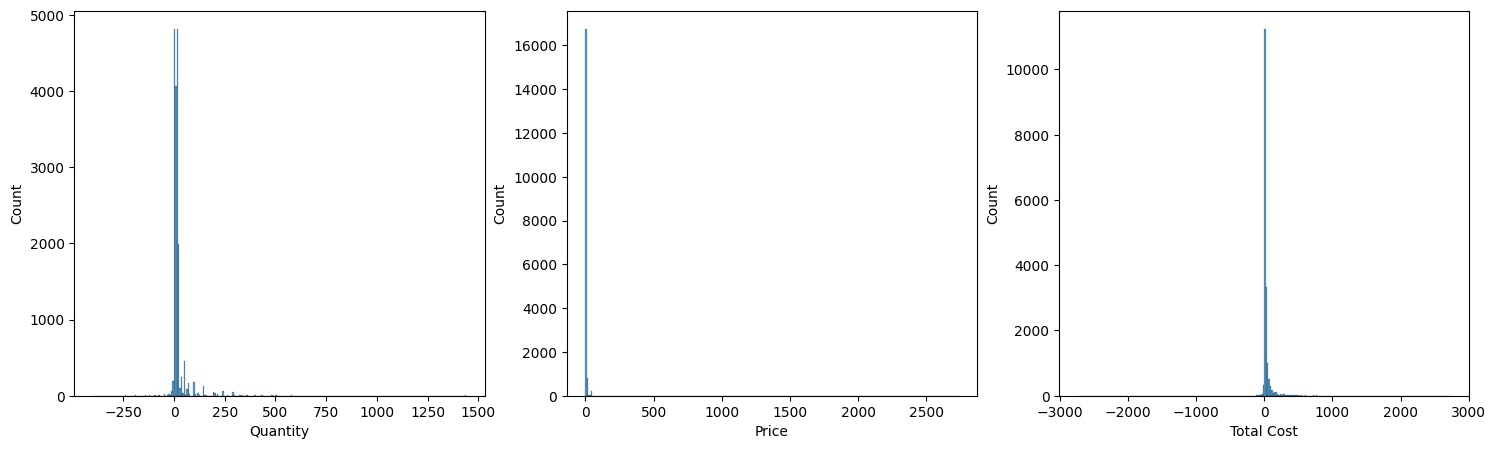

In [219]:
# The outliers make the majority of data hard to visualise
multi_row_plot(
    sns.histplot,
    eire_data[['Quantity', 'Price', 'Total Cost']],
    grid=(1, 3),
    size=(18, 5),
)

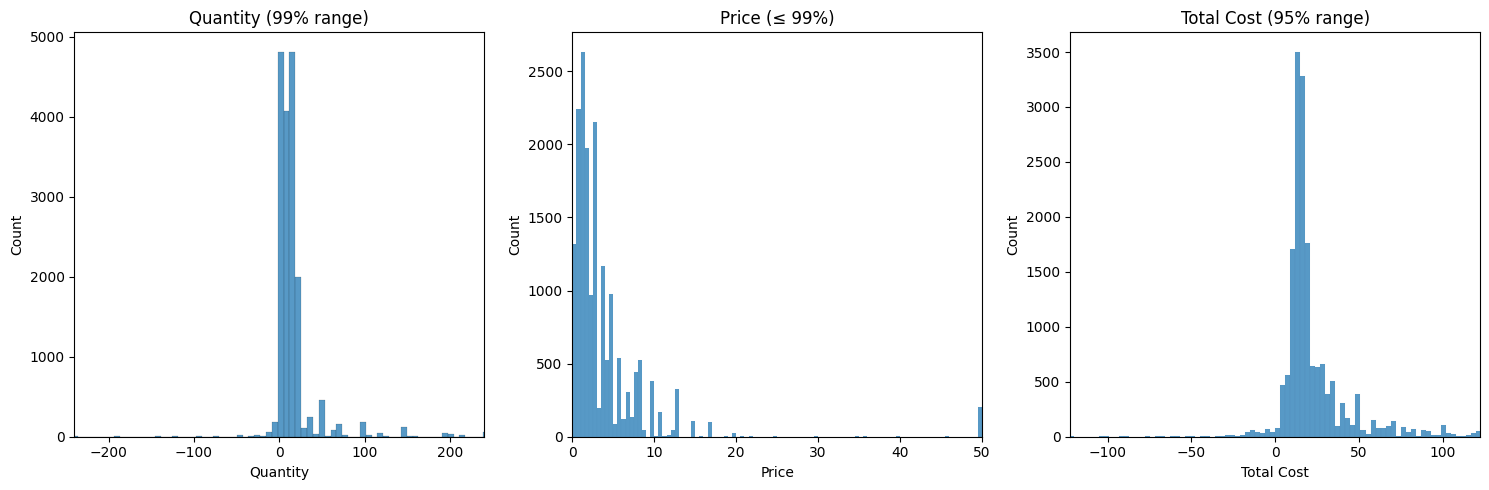

In [220]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Quantity (99% range) ---
sns.histplot(eire_data['Quantity'], ax=axes[0])
q99 = eire_data['Quantity'].abs().quantile(0.99)
axes[0].set_xlim(-q99, q99)
axes[0].set_title('Quantity (99% range)')

# --- Price (≤ 99%) ---
sns.histplot(eire_data['Price'], binwidth=0.5, ax=axes[1])
axes[1].set_xlim(0, eire_data['Price'].quantile(0.99))
axes[1].set_title('Price (≤ 99%)')

# --- Total Cost (95% range) ---
sns.histplot(eire_data['Total Cost'], binwidth=3, ax=axes[2])
tc95 = eire_data['Total Cost'].abs().quantile(0.95)
axes[2].set_xlim(-tc95, tc95)
axes[2].set_title('Total Cost (95% range)')

plt.tight_layout()
plt.show()


# Clean Data

Remove returns / cancelled orders / manual entries / non-products / duplicates

In [221]:
# Remove product codes that don't represent products
non_product_codes = ['M', 'C2', 'ADJUST', 'POST', 'D', 'BANK CHARGES']

clean_data_v1 = eire_data[
    ~eire_data['StockCode'].isin(non_product_codes)
].copy()
clean_data_v1


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Cost
440,489520,35751C,PURPLE CURRENT CANDLE RING,12,2009-12-01 11:41:00,0.75,14911.0,EIRE,9.0
441,489520,72739B,WHITE CHOCOLATE SCENT CANDLE,12,2009-12-01 11:41:00,1.25,14911.0,EIRE,15.0
442,489520,22114,HOT WATER BOTTLE TEA AND SYMPATHY,8,2009-12-01 11:41:00,3.95,14911.0,EIRE,31.6
443,489520,22212,FOUR HOOK WHITE LOVEBIRDS,6,2009-12-01 11:41:00,2.10,14911.0,EIRE,12.6
444,489520,21523,FANCY FONT HOME SWEET HOME DOORMAT,2,2009-12-01 11:41:00,6.75,14911.0,EIRE,13.5
...,...,...,...,...,...,...,...,...,...
1064612,581433,22192,BLUE DINER WALL CLOCK,2,2011-12-08 15:54:00,8.50,14911.0,EIRE,17.0
1064613,581433,48187,DOORMAT NEW ENGLAND,2,2011-12-08 15:54:00,8.25,14911.0,EIRE,16.5
1064614,581433,48184,DOORMAT ENGLISH ROSE,2,2011-12-08 15:54:00,8.25,14911.0,EIRE,16.5
1064615,581433,20685,DOORMAT RED RETROSPOT,2,2011-12-08 15:54:00,8.25,14911.0,EIRE,16.5


In [222]:
clean_data_v1.info()
clean_data_v1.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 17583 entries, 440 to 1064616
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      17583 non-null  object        
 1   StockCode    17583 non-null  object        
 2   Description  17583 non-null  object        
 3   Quantity     17583 non-null  int64         
 4   InvoiceDate  17583 non-null  datetime64[ns]
 5   Price        17583 non-null  float64       
 6   Customer ID  15946 non-null  float64       
 7   Country      17583 non-null  object        
 8   Total Cost   17583 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 1.3+ MB


,Quantity,InvoiceDate,Price,Customer ID,Total Cost
count,17583.000000,17583,17583.000000,15946.000000,17583.000000
mean,18.832736,2010-12-24 07:17:29.868622848,3.485544,14692.772858,34.609133
min,-400.000000,2009-12-01 11:41:00,0.000000,14016.000000,-1224.000000
25%,4.000000,2010-06-30 09:37:00,1.250000,14156.000000,13.500000
50%,10.000000,2010-11-15 14:26:00,2.100000,14911.000000,17.400000
75%,12.000000,2011-07-28 15:16:00,4.650000,14911.000000,29.700000
max,1440.000000,2011-12-08 15:54:00,165.000000,14911.000000,2365.200000
std,47.548160,NaN,3.958058,347.370486,84.984633


In [223]:
# Remove duplicate entries
key_cols = ['Invoice', 'Customer ID', 'InvoiceDate', 'StockCode', 'Quantity']

duplicates = clean_data_v1[
    clean_data_v1.duplicated(subset=key_cols, keep=False)
]
duplicates.info()
duplicates.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 180796 to 971559
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      392 non-null    object        
 1   StockCode    392 non-null    object        
 2   Description  392 non-null    object        
 3   Quantity     392 non-null    int64         
 4   InvoiceDate  392 non-null    datetime64[ns]
 5   Price        392 non-null    float64       
 6   Customer ID  356 non-null    float64       
 7   Country      392 non-null    object        
 8   Total Cost   392 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.6+ KB


,Quantity,InvoiceDate,Price,Customer ID,Total Cost
count,392.000000,392,392.000000,356.000000,392.000000
mean,19.933673,2010-12-09 15:01:30.000000256,4.053929,14860.101124,27.631480
min,-24.000000,2010-04-30 11:48:00,0.120000,14156.000000,-61.200000
25%,4.000000,2010-12-03 14:04:00,1.250000,14911.000000,15.000000
50%,10.000000,2010-12-03 14:04:00,2.100000,14911.000000,19.900000
75%,12.000000,2010-12-06 13:06:00,5.950000,14911.000000,31.600000
max,1440.000000,2011-11-07 13:06:00,21.950000,14911.000000,230.400000
std,102.788889,NaN,4.219305,189.575600,29.284998


In [224]:
# Drop duplicates
clean_data_v2 = clean_data_v1.drop_duplicates(
    subset=key_cols, keep='first'
).copy()
clean_data_v2.info()
clean_data_v2.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 17387 entries, 440 to 1064616
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      17387 non-null  object        
 1   StockCode    17387 non-null  object        
 2   Description  17387 non-null  object        
 3   Quantity     17387 non-null  int64         
 4   InvoiceDate  17387 non-null  datetime64[ns]
 5   Price        17387 non-null  float64       
 6   Customer ID  15768 non-null  float64       
 7   Country      17387 non-null  object        
 8   Total Cost   17387 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 1.3+ MB


,Quantity,InvoiceDate,Price,Customer ID,Total Cost
count,17387.000000,17387,17387.000000,15768.000000,17387.000000
mean,18.820326,2010-12-24 11:15:45.568528128,3.479137,14690.883942,34.687790
min,-400.000000,2009-12-01 11:41:00,0.000000,14016.000000,-1224.000000
25%,4.000000,2010-06-25 10:22:00,1.250000,14156.000000,13.500000
50%,10.000000,2010-11-12 10:28:00,2.100000,14911.000000,17.400000
75%,12.000000,2011-07-29 13:39:00,4.250000,14911.000000,29.500000
max,1440.000000,2011-12-08 15:54:00,165.000000,14911.000000,2365.200000
std,46.556360,NaN,3.954614,348.287608,85.402636


In [225]:
clean_data_v2['InvoiceDate'] = pd.to_datetime(clean_data_v2['InvoiceDate'])

# Create month-based columns
clean_data_v2['Year-Month'] = clean_data_v2['InvoiceDate'].dt.to_period('M')
clean_data_v2['MonthName'] = clean_data_v2['InvoiceDate'].dt.month_name()

# Inspect result
clean_data_v2.info()
clean_data_v2.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 17387 entries, 440 to 1064616
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      17387 non-null  object        
 1   StockCode    17387 non-null  object        
 2   Description  17387 non-null  object        
 3   Quantity     17387 non-null  int64         
 4   InvoiceDate  17387 non-null  datetime64[ns]
 5   Price        17387 non-null  float64       
 6   Customer ID  15768 non-null  float64       
 7   Country      17387 non-null  object        
 8   Total Cost   17387 non-null  float64       
 9   Year-Month   17387 non-null  period[M]     
 10  MonthName    17387 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(5), period[M](1)
memory usage: 1.6+ MB


,Quantity,InvoiceDate,Price,Customer ID,Total Cost
count,17387.000000,17387,17387.000000,15768.000000,17387.000000
mean,18.820326,2010-12-24 11:15:45.568528128,3.479137,14690.883942,34.687790
min,-400.000000,2009-12-01 11:41:00,0.000000,14016.000000,-1224.000000
25%,4.000000,2010-06-25 10:22:00,1.250000,14156.000000,13.500000
50%,10.000000,2010-11-12 10:28:00,2.100000,14911.000000,17.400000
75%,12.000000,2011-07-29 13:39:00,4.250000,14911.000000,29.500000
max,1440.000000,2011-12-08 15:54:00,165.000000,14911.000000,2365.200000
std,46.556360,NaN,3.954614,348.287608,85.402636


In [226]:
clean_data_v2['StockCode'] = clean_data_v2['StockCode'].astype(str)
clean_data_v2.to_csv('clean_data_v2.csv')
clean_data_v2


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Cost,Year-Month,MonthName
440,489520,35751C,PURPLE CURRENT CANDLE RING,12,2009-12-01 11:41:00,0.75,14911.0,EIRE,9.0,2009-12,December
441,489520,72739B,WHITE CHOCOLATE SCENT CANDLE,12,2009-12-01 11:41:00,1.25,14911.0,EIRE,15.0,2009-12,December
442,489520,22114,HOT WATER BOTTLE TEA AND SYMPATHY,8,2009-12-01 11:41:00,3.95,14911.0,EIRE,31.6,2009-12,December
443,489520,22212,FOUR HOOK WHITE LOVEBIRDS,6,2009-12-01 11:41:00,2.10,14911.0,EIRE,12.6,2009-12,December
444,489520,21523,FANCY FONT HOME SWEET HOME DOORMAT,2,2009-12-01 11:41:00,6.75,14911.0,EIRE,13.5,2009-12,December
...,...,...,...,...,...,...,...,...,...,...,...
1064612,581433,22192,BLUE DINER WALL CLOCK,2,2011-12-08 15:54:00,8.50,14911.0,EIRE,17.0,2011-12,December
1064613,581433,48187,DOORMAT NEW ENGLAND,2,2011-12-08 15:54:00,8.25,14911.0,EIRE,16.5,2011-12,December
1064614,581433,48184,DOORMAT ENGLISH ROSE,2,2011-12-08 15:54:00,8.25,14911.0,EIRE,16.5,2011-12,December
1064615,581433,20685,DOORMAT RED RETROSPOT,2,2011-12-08 15:54:00,8.25,14911.0,EIRE,16.5,2011-12,December


In [227]:
# Merge columns on their stock code to total the amount paid for each product
product_revenue = clean_data_v2.groupby('StockCode', as_index=False).agg(
    {
        'InvoiceDate': 'first',
        'Description': 'first',
        'Quantity': 'sum',
        'Price': 'mean',
        'Total Cost': 'sum',
    }
)
product_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   StockCode    2838 non-null   object        
 1   InvoiceDate  2838 non-null   datetime64[ns]
 2   Description  2838 non-null   object        
 3   Quantity     2838 non-null   int64         
 4   Price        2838 non-null   float64       
 5   Total Cost   2838 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 133.2+ KB


In [228]:
product_revenue.to_csv('stock_revenue.csv')

# Data Exploration

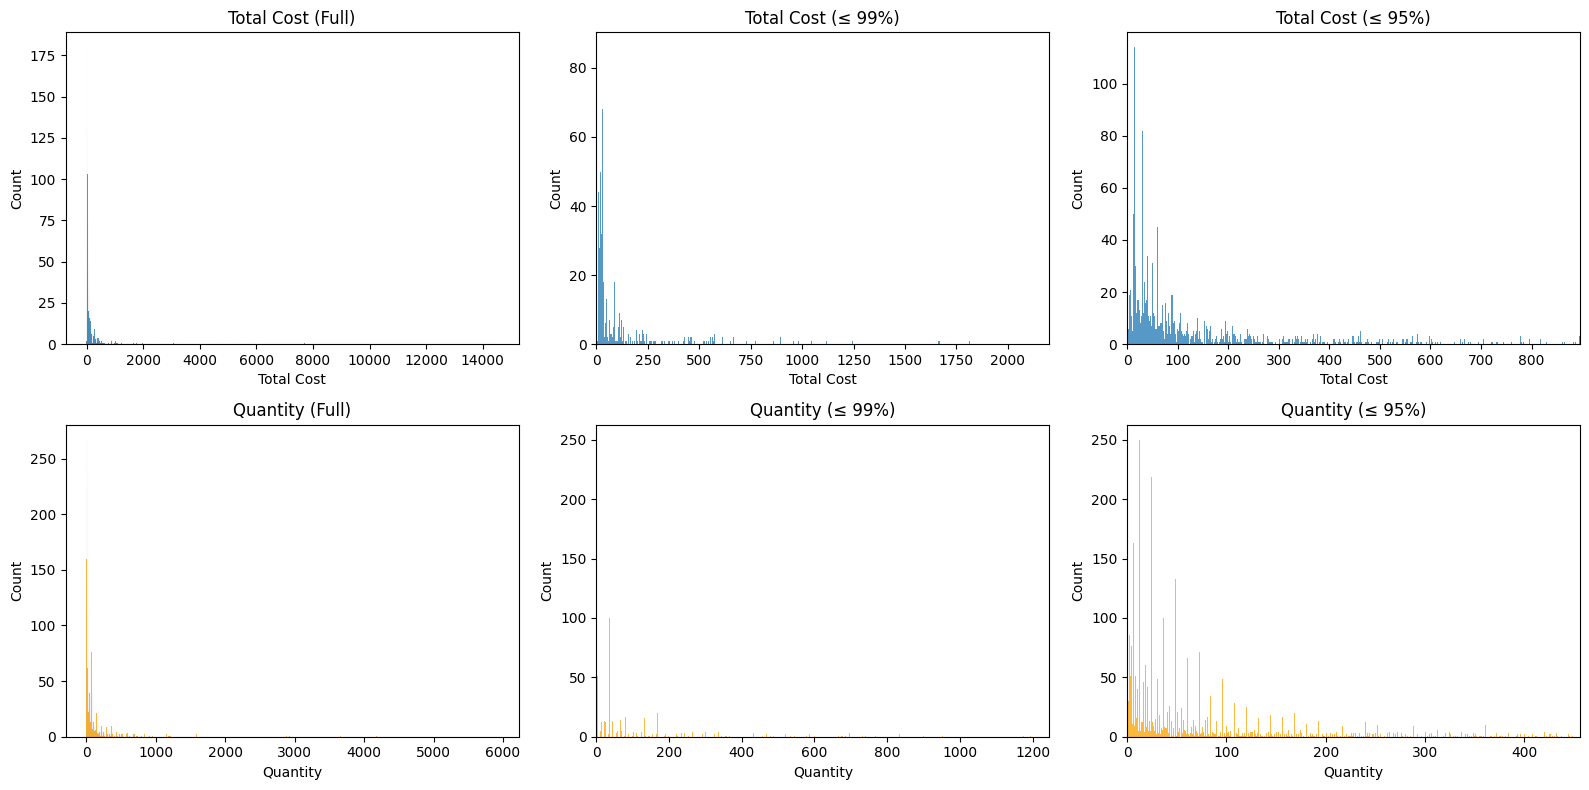

In [229]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

metrics = [
    ('Total Cost', 'Total Cost'),
    ('Quantity', 'Quantity'),
]

views = [
    ('Full', None, 3),
    ('≤ 99%', 0.99, 0.5),
    ('≤ 95%', 0.95, 1),
]

for row, (col, title_prefix) in enumerate(metrics):
    for col_idx, (label, q, binw) in enumerate(views):
        ax = axes[row, col_idx]

        # Make Quantity orange
        plot_color = 'orange' if col == 'Quantity' else None

        sns.histplot(
            product_revenue[col], binwidth=binw, ax=ax, color=plot_color
        )

        if q is not None:
            ax.set_xlim(0, product_revenue[col].quantile(q))

        ax.set_title(f'{title_prefix} ({label})')

plt.tight_layout()
plt.show()


In [230]:
top_20_products_cost = product_revenue.sort_values(
    'Total Cost', ascending=False
).head(20)

top_20_products_cost

,StockCode,InvoiceDate,Description,Quantity,Price,Total Cost
1149,22423,2010-03-22 11:21:00,REGENCY CAKESTAND 3 TIER,1275,12.094481,14537.55
198,20914,2009-12-08 13:49:00,SET/5 RED SPOTTY LID GLASS BOWLS,2922,2.846774,7698.70
727,21843,2009-12-07 13:49:00,RETRO SPOT CAKE STAND,565,10.932143,6162.75
2648,85123A,2009-12-07 09:25:00,WHITE HANGING HEART T-LIGHT HOLDER,2071,2.845455,5560.65
321,21166,2010-02-07 14:27:00,COOK WITH WINE METAL SIGN,3091,1.934792,5528.08
329,21181,2009-12-01 11:41:00,PLEASE ONE PERSON METAL SIGN,2670,2.037500,5031.00
519,21523,2009-12-01 11:41:00,FANCY FONT HOME SWEET HOME DOORMAT,692,7.219149,4574.40
102,20685,2009-12-21 13:04:00,RED SPOTTY COIR DOORMAT,696,7.071111,4490.42
322,21169,2010-02-07 14:27:00,YOU'RE CONFUSING ME METAL SIGN,2855,1.560769,4179.83
520,21524,2010-01-07 12:34:00,SPOTTY HOME SWEET HOME DOORMAT,599,7.292889,3907.13


In [231]:
top_20_products_quantity = product_revenue.sort_values(
    'Quantity', ascending=False
).head(20)

top_20_products_quantity

,StockCode,InvoiceDate,Description,Quantity,Price,Total Cost
351,21212,2009-12-01 12:30:00,PACK OF 72 RETRO SPOT CAKE CASES,5928,0.529551,2776.80
2555,84991,2009-12-01 12:33:00,60 TEATIME FAIRY CAKE CASES,5556,0.527531,2587.80
805,21977,2009-12-01 12:33:00,PACK OF 60 PINK PAISLEY CAKE CASES,4188,0.531429,1960.20
2556,84992,2009-12-16 10:51:00,72 SWEETHEART FAIRY CAKE CASES,4176,0.515510,1875.60
968,22197,2009-12-15 12:00:00,"POPCORN HOLDER , SMALL",3658,0.833750,2798.34
803,21975,2009-12-21 13:04:00,PACK OF 60 DINOSAUR CAKE CASES,3336,0.519048,1507.20
321,21166,2010-02-07 14:27:00,COOK WITH WINE METAL SIGN,3091,1.934792,5528.08
198,20914,2009-12-08 13:49:00,SET/5 RED SPOTTY LID GLASS BOWLS,2922,2.846774,7698.70
61,17084R,2010-03-05 10:20:00,ASSORTED INCENSE PACK,2880,0.160000,460.80
322,21169,2010-02-07 14:27:00,YOU'RE CONFUSING ME METAL SIGN,2855,1.560769,4179.83


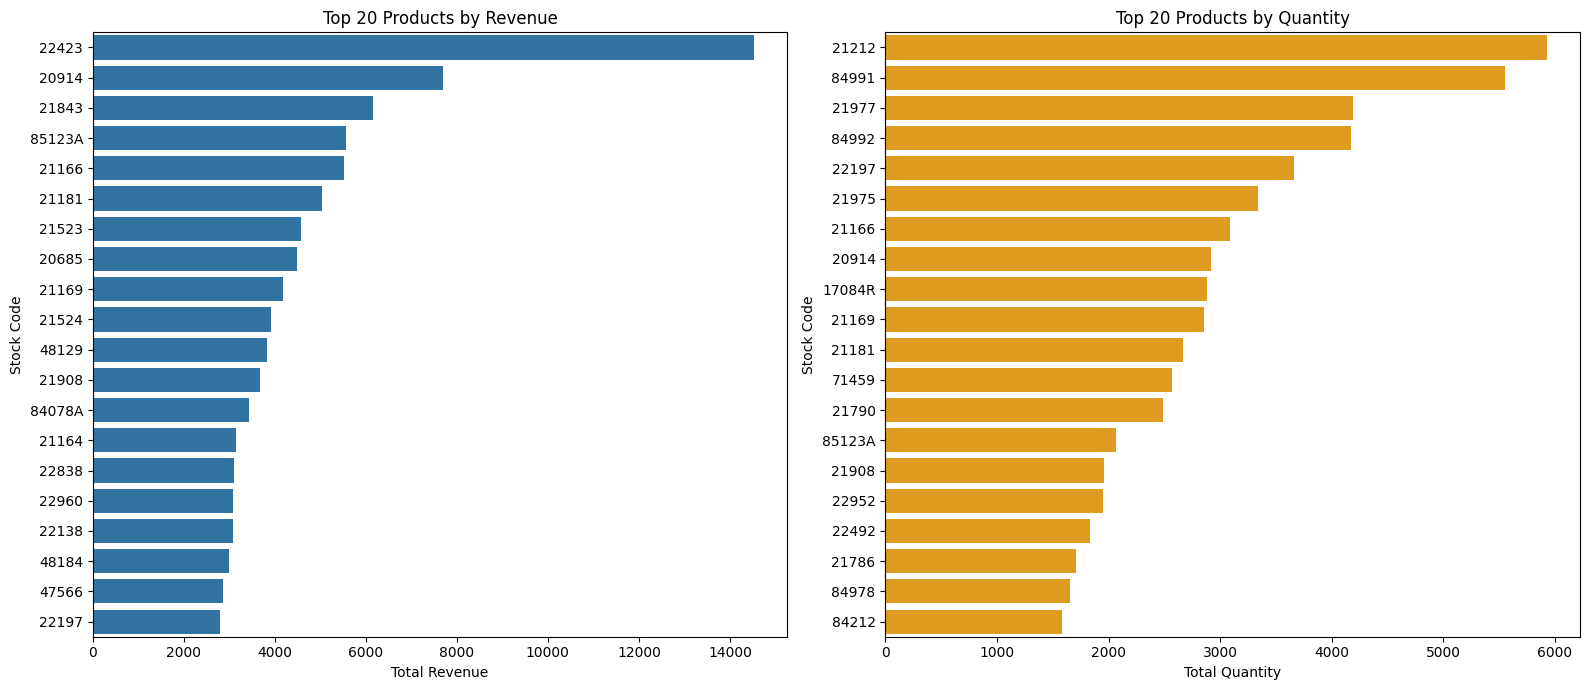

In [232]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Top 20 by revenue
sns.barplot(
    data=top_20_products_cost,
    x='Total Cost',
    y='StockCode',
    orient='h',
    ax=axes[0],
)
axes[0].set_title('Top 20 Products by Revenue')
axes[0].set_xlabel('Total Revenue')
axes[0].set_ylabel('Stock Code')

# Top 20 by quantity
sns.barplot(
    data=top_20_products_quantity,
    x='Quantity',
    y='StockCode',
    orient='h',
    ax=axes[1],
    color='orange',
)
axes[1].set_title('Top 20 Products by Quantity')
axes[1].set_xlabel('Total Quantity')
axes[1].set_ylabel('Stock Code')

plt.tight_layout()
plt.show()


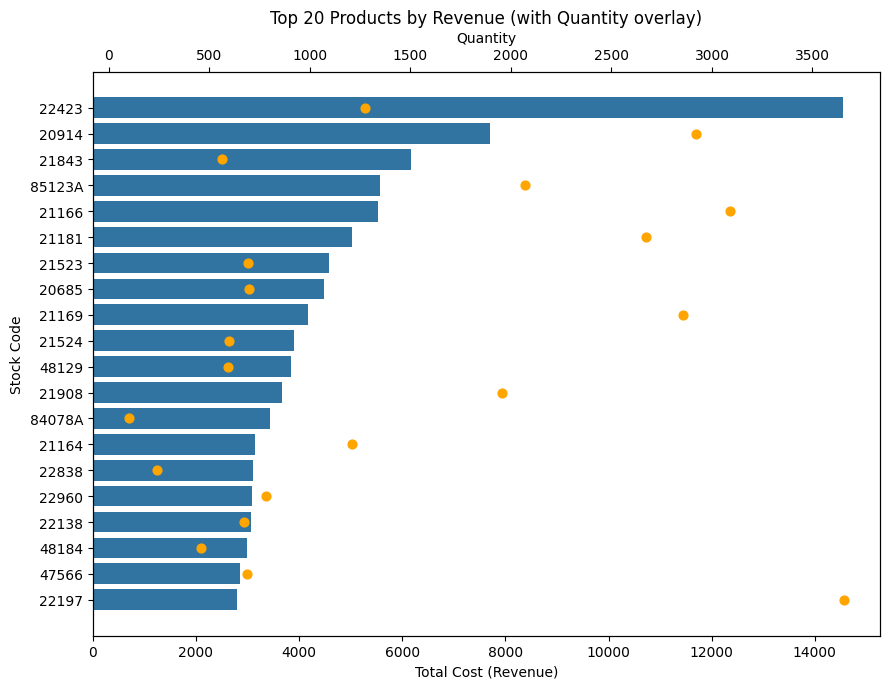

In [233]:
product_revenue['StockCode'] = product_revenue['StockCode'].astype(str)
top_20_products_cost['StockCode'] = top_20_products_cost['StockCode'].astype(
    str
)

# Join Quantity onto the revenue top 20 list
top20_cost_both = (
    top_20_products_cost[['StockCode', 'Total Cost']]
    .merge(
        product_revenue[['StockCode', 'Quantity']], on='StockCode', how='left'
    )
    .sort_values('Total Cost', ascending=False)
)

fig, ax1 = plt.subplots(figsize=(9, 7))

# Bars: Total Cost
sns.barplot(
    data=top20_cost_both, x='Total Cost', y='StockCode', orient='h', ax=ax1
)
ax1.set_title('Top 20 Products by Revenue (with Quantity overlay)')
ax1.set_xlabel('Total Cost (Revenue)')
ax1.set_ylabel('Stock Code')

# Second x-axis for Quantity
ax2 = ax1.twiny()
ax2.scatter(
    top20_cost_both['Quantity'],
    top20_cost_both['StockCode'],
    color='orange',
    s=40,
    label='Quantity',
)
ax2.set_xlabel('Quantity')
ax2.grid(False)

plt.tight_layout()
plt.show()


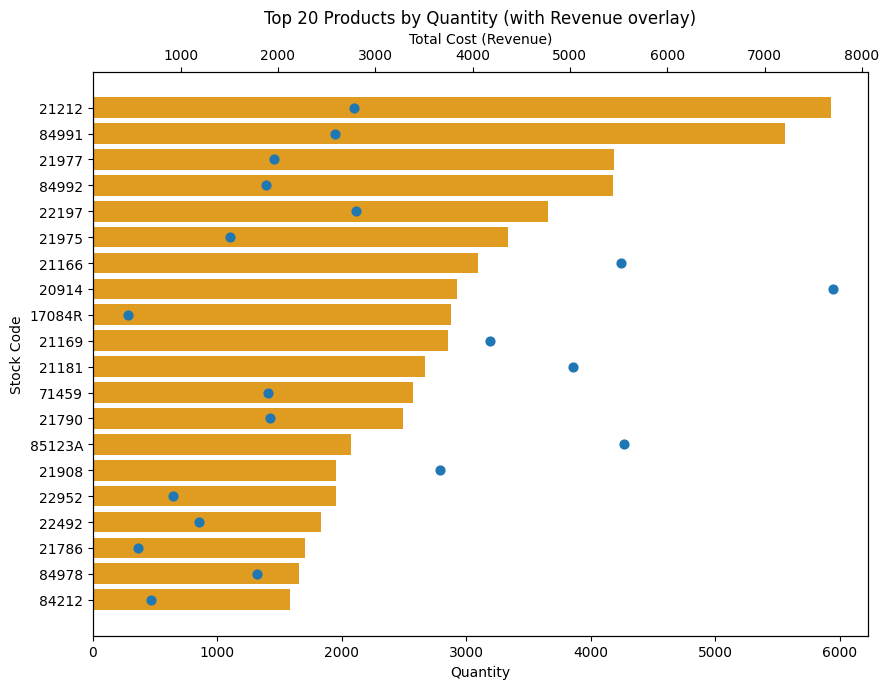

In [234]:
top_20_products_quantity['StockCode'] = top_20_products_quantity[
    'StockCode'
].astype(str)

# Join Total Cost onto the quantity top 20 list
top20_qty_both = (
    top_20_products_quantity[['StockCode', 'Quantity']]
    .merge(
        product_revenue[['StockCode', 'Total Cost']],
        on='StockCode',
        how='left',
    )
    .sort_values('Quantity', ascending=False)
)

fig, ax1 = plt.subplots(figsize=(9, 7))

# Bars: Quantity (orange)
sns.barplot(
    data=top20_qty_both,
    x='Quantity',
    y='StockCode',
    orient='h',
    ax=ax1,
    color='orange',
)
ax1.set_title('Top 20 Products by Quantity (with Revenue overlay)')
ax1.set_xlabel('Quantity')
ax1.set_ylabel('Stock Code')

# Second x-axis for Total Cost
ax2 = ax1.twiny()
ax2.scatter(
    top20_qty_both['Total Cost'],
    top20_qty_both['StockCode'],
    s=40,
    label='Total Cost',
)
ax2.set_xlabel('Total Cost (Revenue)')
ax2.grid(False)

plt.tight_layout()
plt.show()


In [235]:
top_20_monthly_cost = (
    clean_data_v2[
        clean_data_v2['StockCode'].isin(top_20_products_cost['StockCode'])
    ]
    .groupby(['StockCode', 'Year-Month'], as_index=False)['Total Cost']
    .sum()
    .sort_values(['StockCode', 'Year-Month'])
)
top_20_monthly_cost

,StockCode,Year-Month,Total Cost
0,20685,2009-12,238.00
1,20685,2010-01,906.00
2,20685,2010-02,254.00
3,20685,2010-03,283.96
4,20685,2010-05,29.96
...,...,...,...
336,85123A,2011-08,198.60
337,85123A,2011-09,159.30
338,85123A,2011-10,287.70
339,85123A,2011-11,1120.80


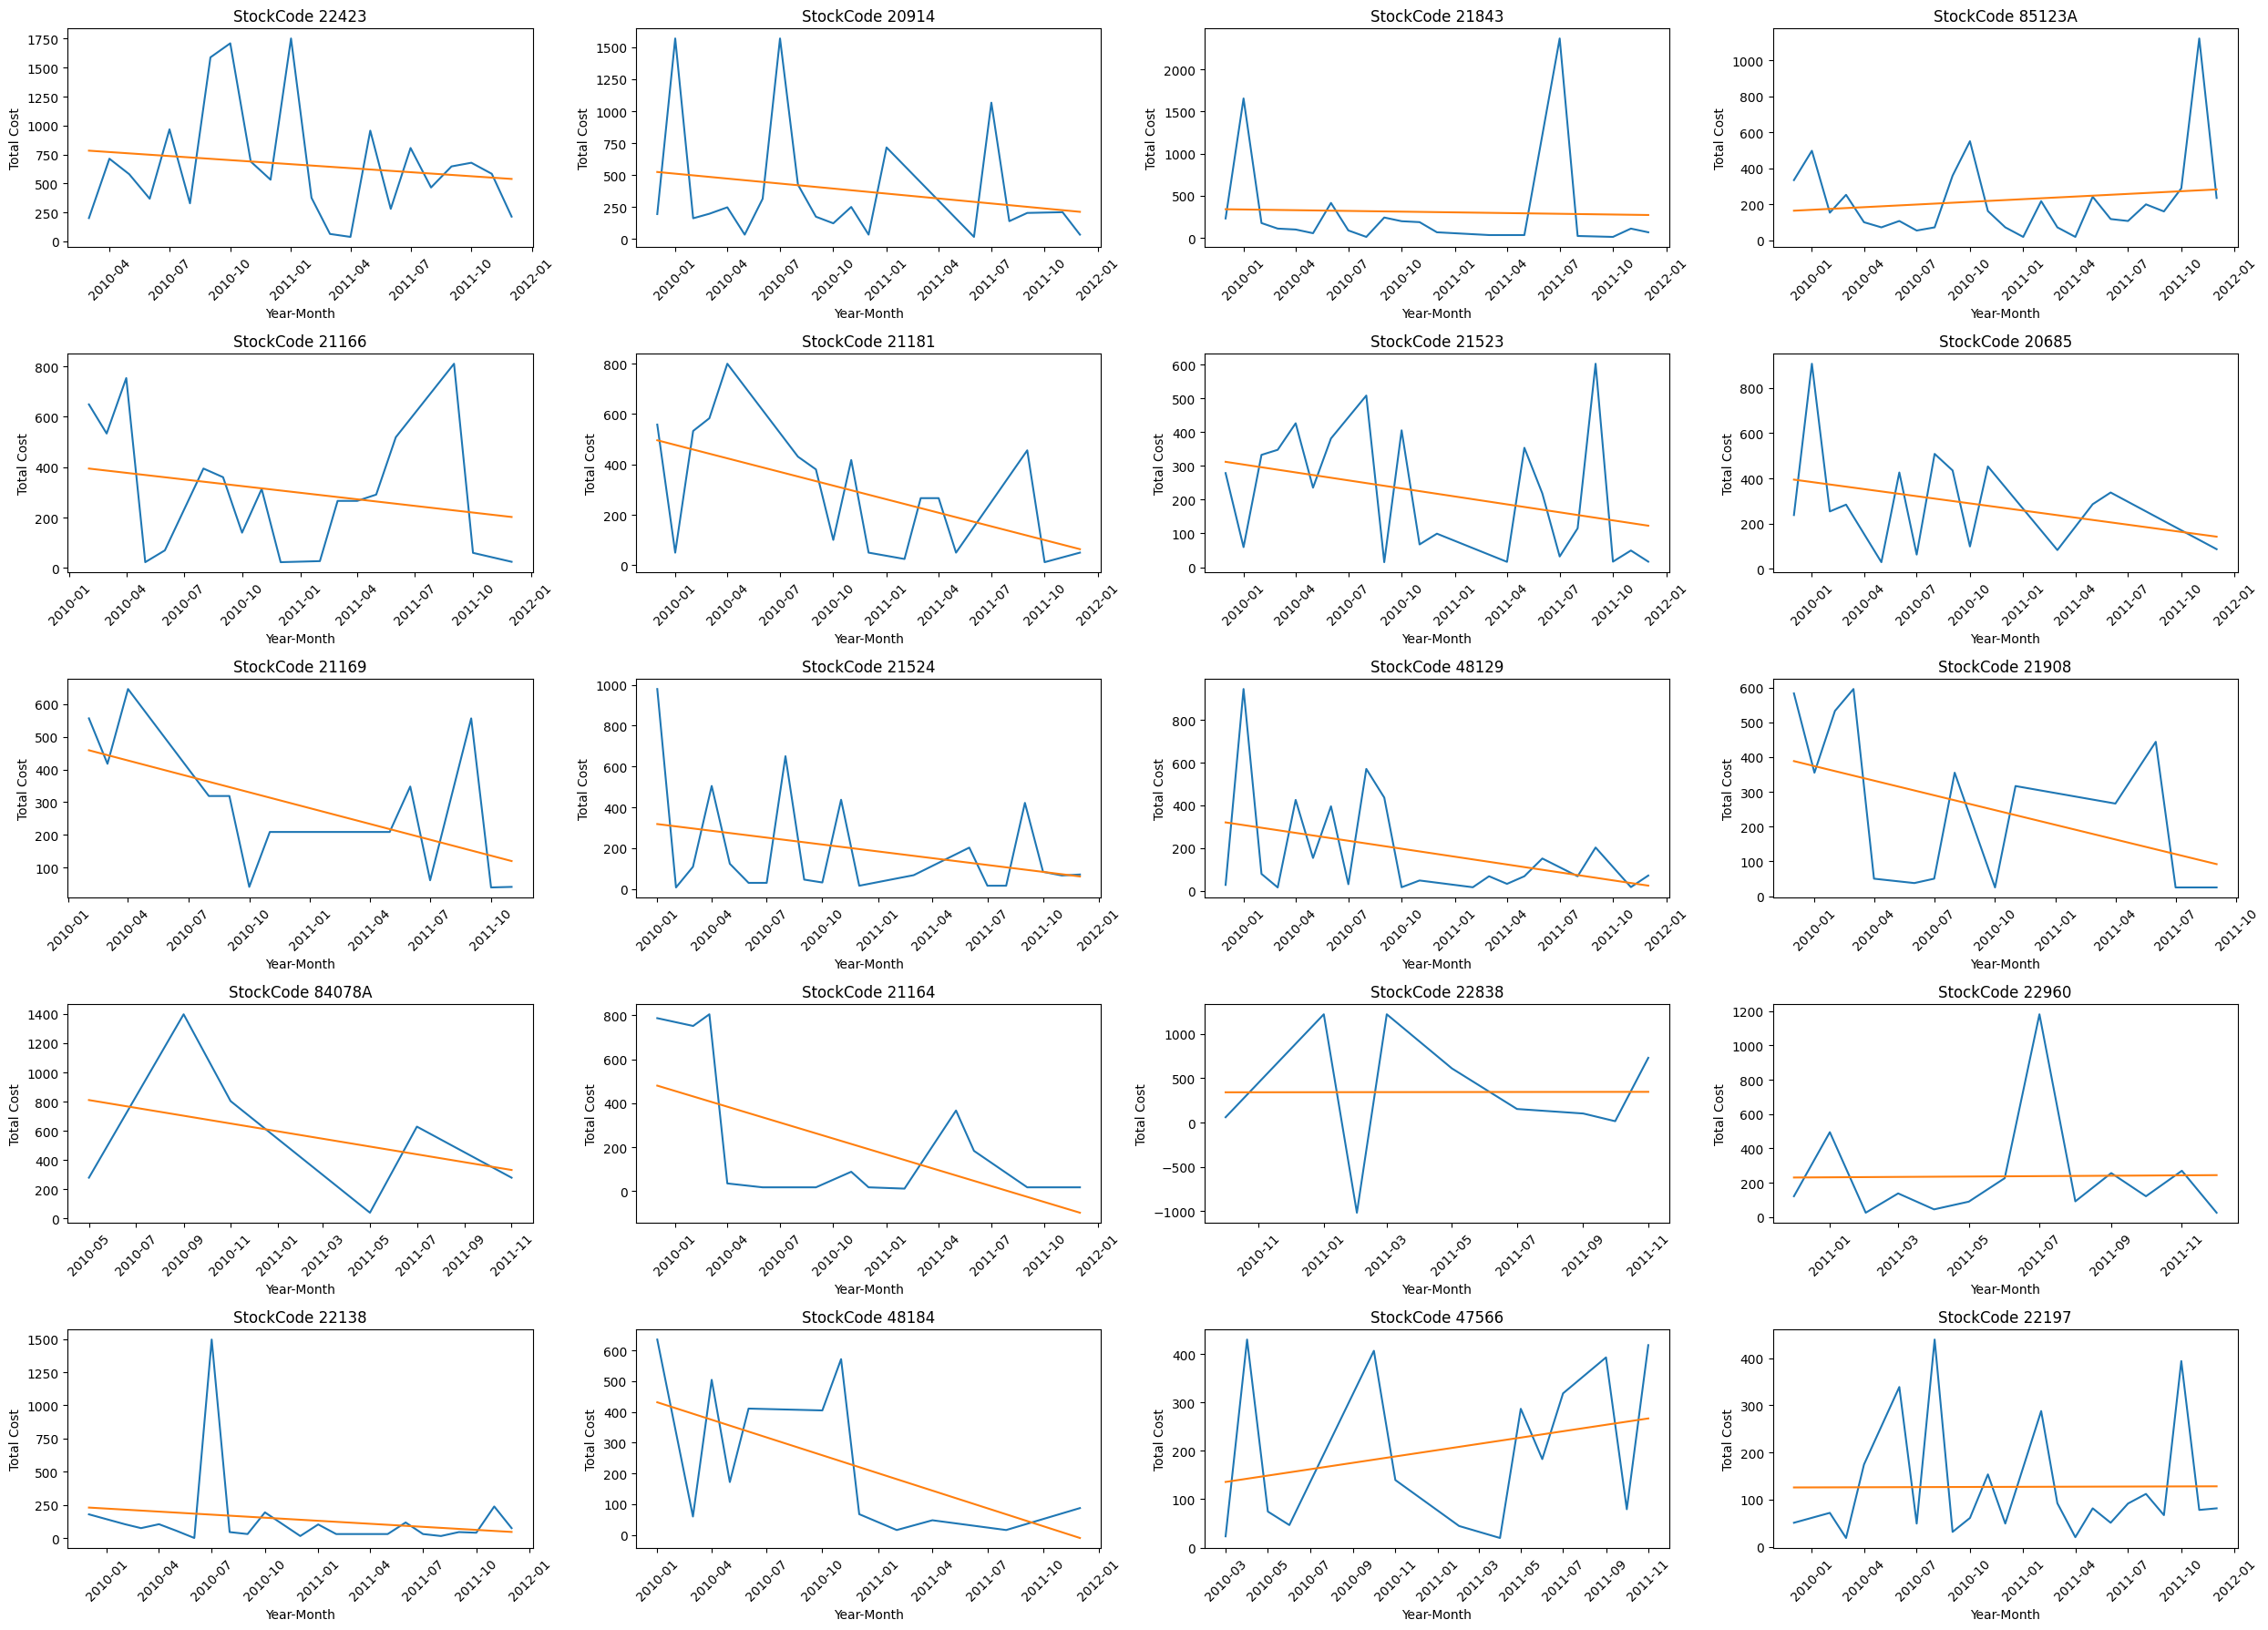

In [236]:
top_year_month_cost = top_20_monthly_cost.copy()
top_year_month_cost['Year-Month'] = top_year_month_cost[
    'Year-Month'
].dt.to_timestamp()

fig, axes = plt.subplots(5, 4, figsize=(25, 18))
axes = axes.flatten()

for ax, code in zip(axes, top_20_products_cost['StockCode']):
    subset = (
        top_year_month_cost[top_year_month_cost['StockCode'] == code]
        .sort_values('Year-Month')
        .copy()
    )

    sns.lineplot(data=subset, x='Year-Month', y='Total Cost', ax=ax)

    # Fit a simple linear trend line (least squares)
    x = subset['Year-Month'].map(lambda d: d.toordinal()).to_numpy()
    y = subset['Total Cost'].to_numpy()

    if len(x) > 1:
        m, b = np.polyfit(x, y, 1)
        subset['Trend'] = m * x + b

        sns.lineplot(data=subset, x='Year-Month', y='Trend', ax=ax)

    ax.set_title(f'StockCode {code}')
    ax.tick_params(axis='x', rotation=45)

for ax in axes[len(top_20_products_cost['StockCode']) :]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [237]:
top_20_monthly_quantity = (
    clean_data_v2[
        clean_data_v2['StockCode'].isin(top_20_products_quantity['StockCode'])
    ]
    .groupby(['StockCode', 'Year-Month'], as_index=False)['Quantity']
    .sum()
    .sort_values(['StockCode', 'Year-Month'])
)
top_20_monthly_quantity

,StockCode,Year-Month,Quantity
0,17084R,2010-03,1440
1,17084R,2010-12,1440
2,20914,2009-12,75
3,20914,2010-01,614
4,20914,2010-02,64
...,...,...,...
335,85123A,2011-08,76
336,85123A,2011-09,54
337,85123A,2011-10,110
338,85123A,2011-11,432


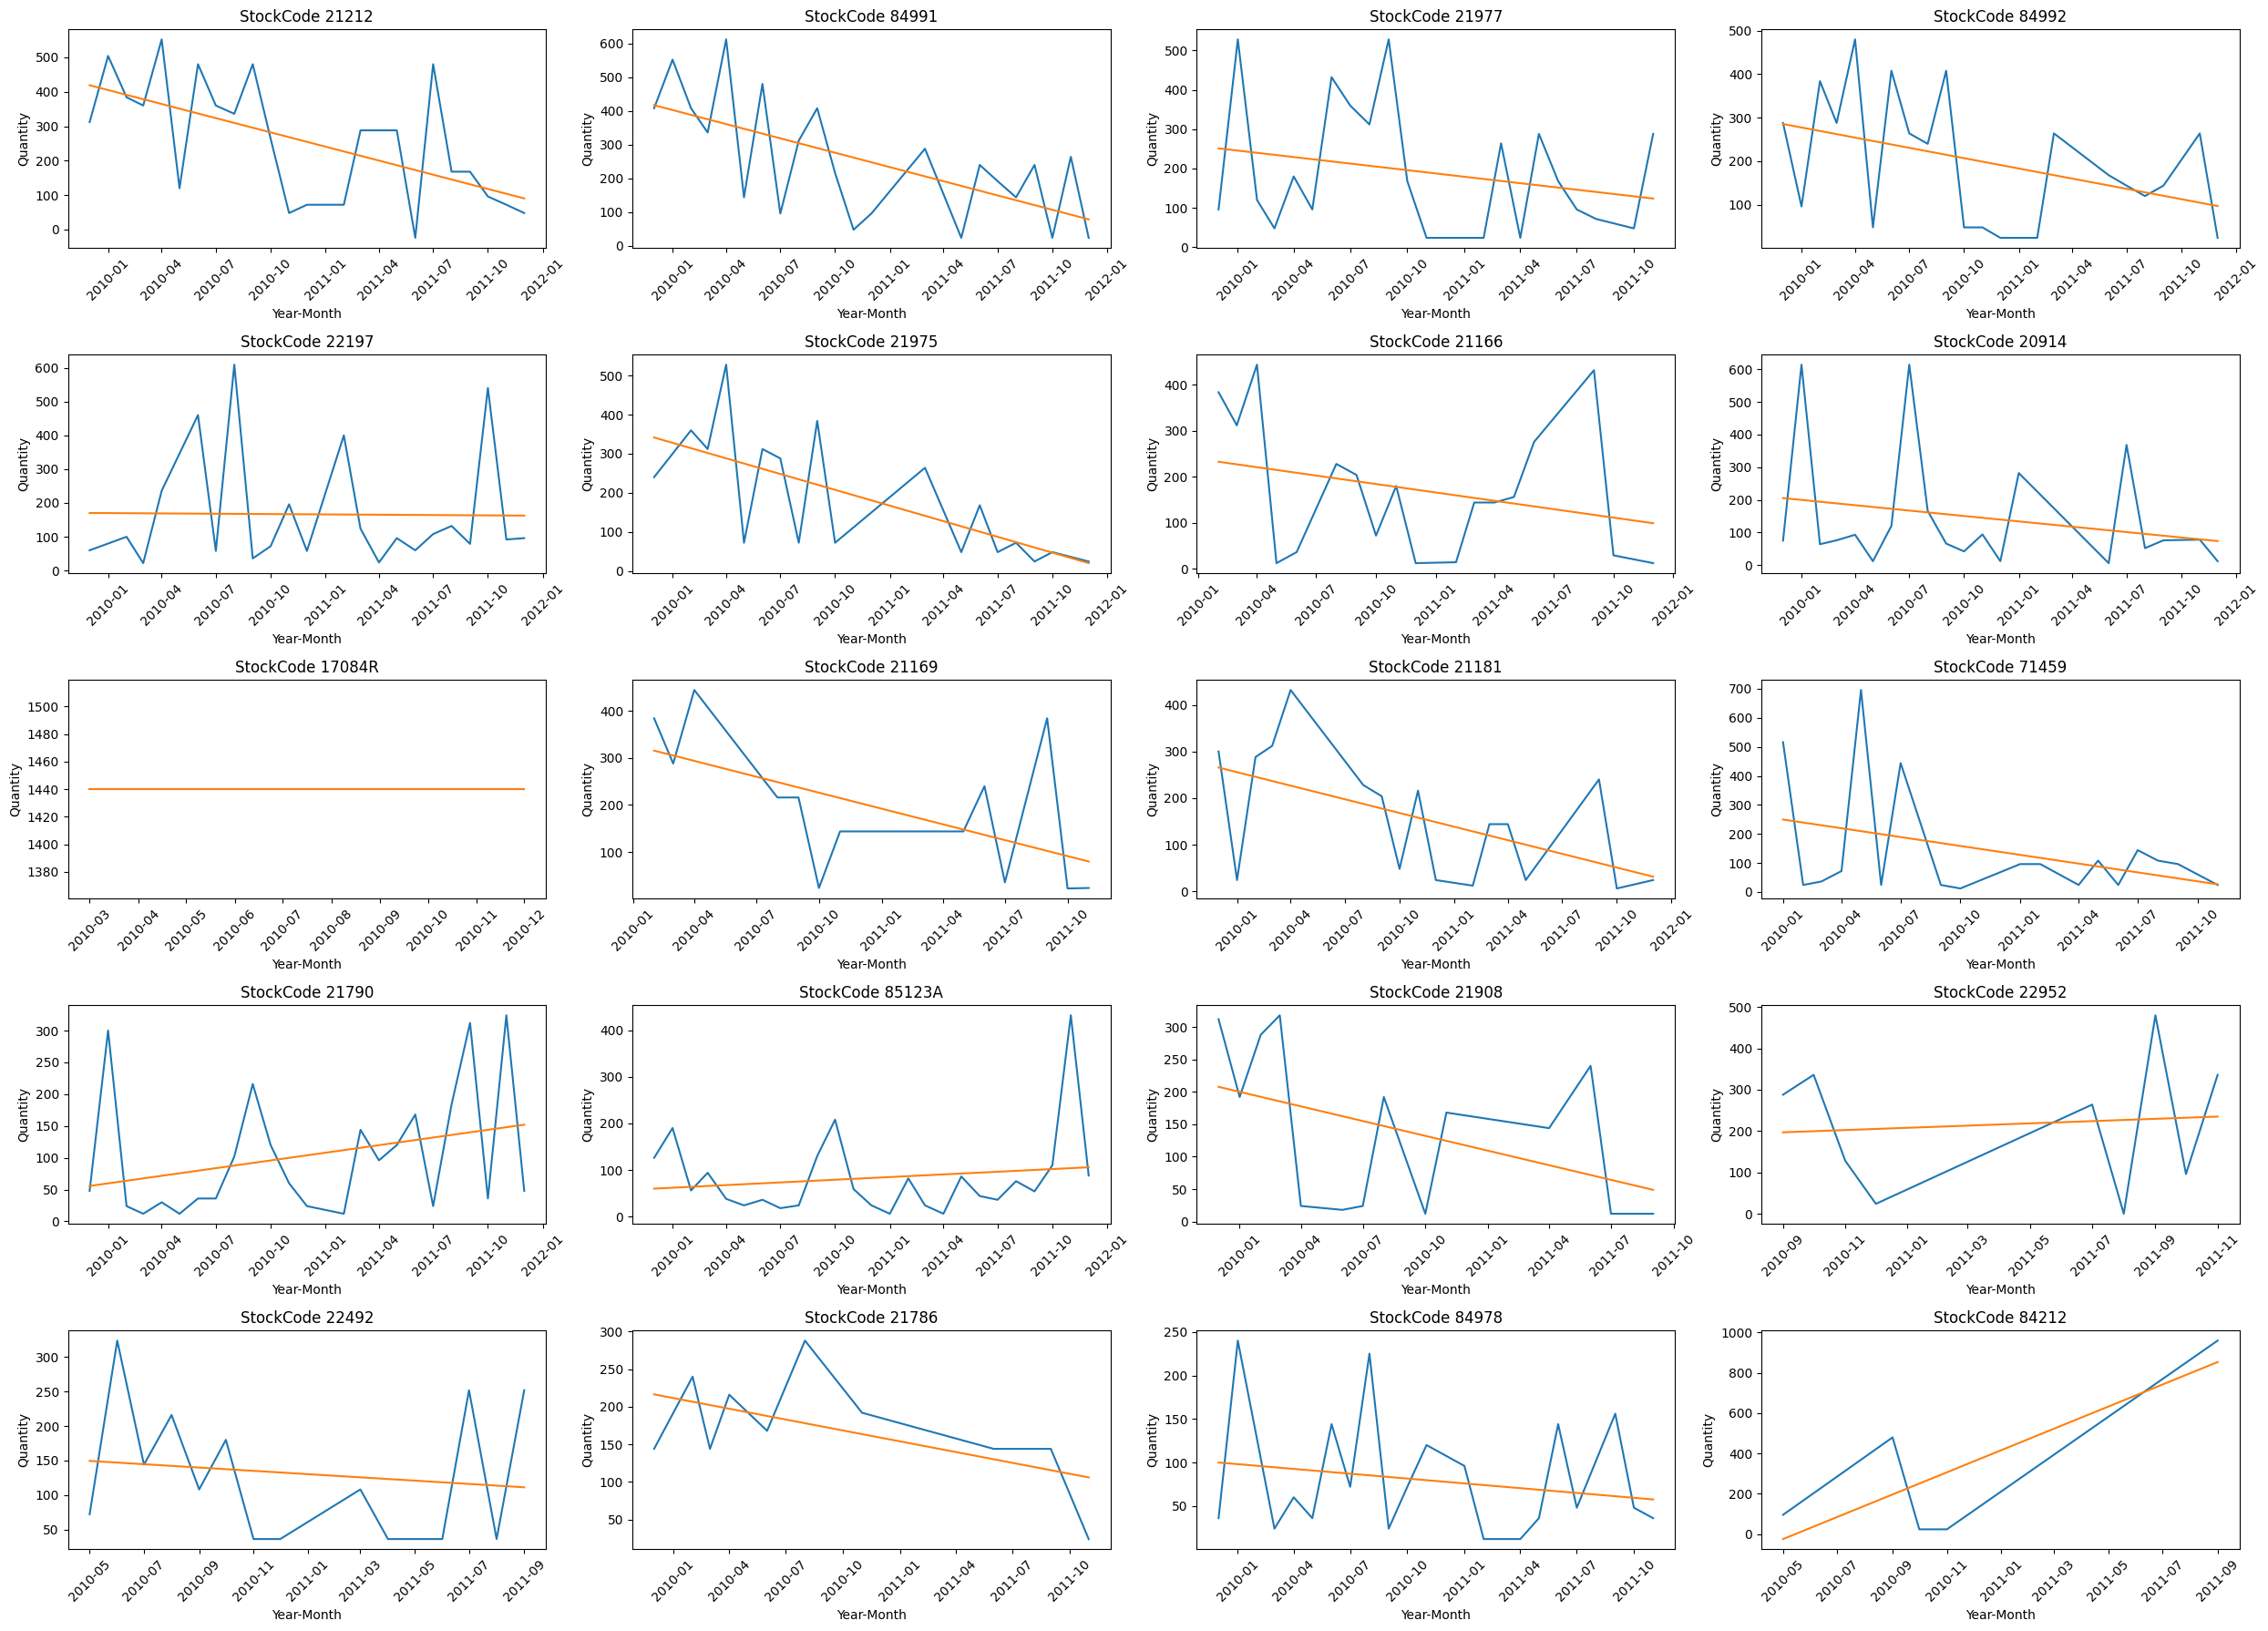

In [238]:
top_year_month_quantity = top_20_monthly_quantity.copy()
top_year_month_quantity['Year-Month'] = top_year_month_quantity[
    'Year-Month'
].dt.to_timestamp()

fig, axes = plt.subplots(5, 4, figsize=(25, 18))
axes = axes.flatten()

for ax, code in zip(axes, top_20_products_quantity['StockCode']):
    subset = (
        top_year_month_quantity[top_year_month_quantity['StockCode'] == code]
        .sort_values('Year-Month')
        .copy()
    )

    sns.lineplot(data=subset, x='Year-Month', y='Quantity', ax=ax)

    # Fit a simple linear trend line (least squares)
    x = subset['Year-Month'].map(lambda d: d.toordinal()).to_numpy()
    y = subset['Quantity'].to_numpy()

    if len(x) > 1:
        m, b = np.polyfit(x, y, 1)
        subset['Trend'] = m * x + b

        sns.lineplot(data=subset, x='Year-Month', y='Trend', ax=ax)

    ax.set_title(f'StockCode {code}')
    ax.tick_params(axis='x', rotation=45)

for ax in axes[len(top_20_products_quantity['StockCode']) :]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [239]:
df_2010_2011 = clean_data_v2[
    clean_data_v2['InvoiceDate'].dt.year.isin([2010, 2011])
].copy()

month_order = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'September',
    'October',
    'November',
    'December',
]

revenue_by_month_2010_2011 = df_2010_2011.groupby('MonthName', as_index=False)[
    'Total Cost'
].sum()

revenue_by_month_2010_2011['MonthName'] = pd.Categorical(
    revenue_by_month_2010_2011['MonthName'],
    categories=month_order,
    ordered=True,
)

revenue_by_month_2010_2011 = revenue_by_month_2010_2011.sort_values(
    'MonthName'
)

revenue_by_month_2010_2011

,MonthName,Total Cost
4,January,79555.55
3,February,29823.39
7,March,39837.21
0,April,30364.45
8,May,36208.28
6,June,41813.01
5,July,75597.97
1,August,38707.59
11,September,72657.18
10,October,64823.86


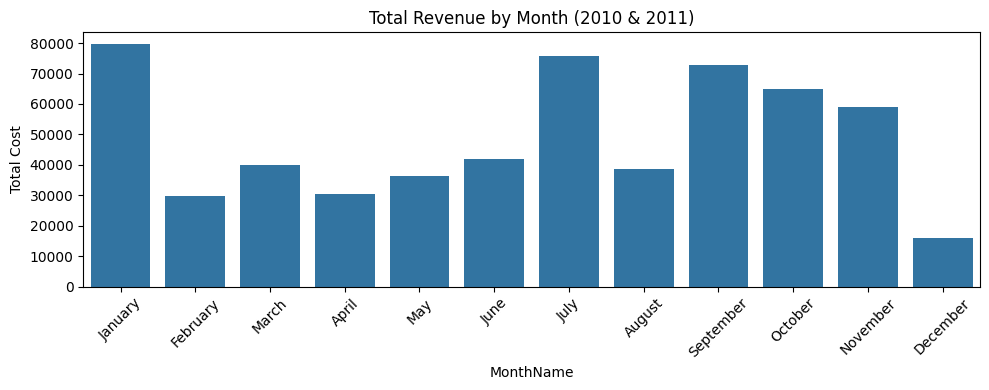

In [240]:
plt.figure(figsize=(10, 4))
sns.barplot(data=revenue_by_month_2010_2011, x='MonthName', y='Total Cost')
plt.xticks(rotation=45)
plt.title('Total Revenue by Month (2010 & 2011)')
plt.tight_layout()
plt.show()


In [241]:
quantity_by_month_2010_2011 = df_2010_2011.groupby(
    'MonthName', as_index=False
)['Quantity'].sum()

quantity_by_month_2010_2011['MonthName'] = pd.Categorical(
    quantity_by_month_2010_2011['MonthName'],
    categories=month_order,
    ordered=True,
)

quantity_by_month_2010_2011 = quantity_by_month_2010_2011.sort_values(
    'MonthName'
)

quantity_by_month_2010_2011

,MonthName,Quantity
4,January,39004
3,February,16899
7,March,24220
0,April,17695
8,May,17709
6,June,24565
5,July,37191
1,August,23653
11,September,40149
10,October,35561


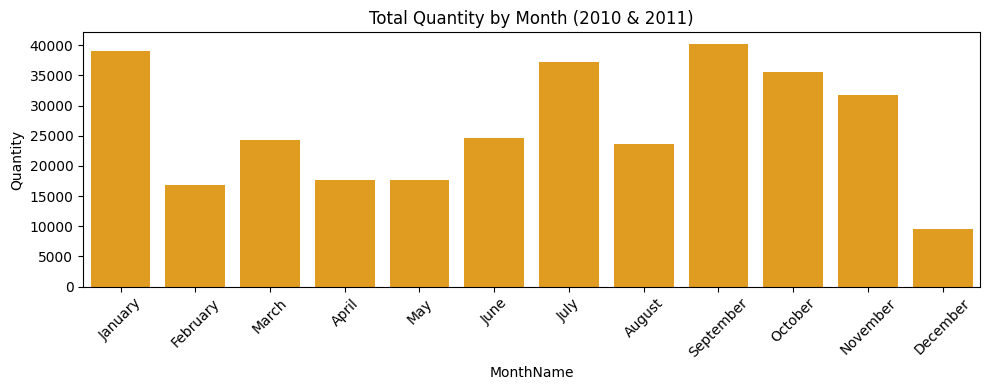

In [242]:
plt.figure(figsize=(10, 4))
sns.barplot(
    data=quantity_by_month_2010_2011,
    x='MonthName',
    y='Quantity',
    color='orange',
)
plt.xticks(rotation=45)
plt.title('Total Quantity by Month (2010 & 2011)')
plt.tight_layout()
plt.show()


# Task
Refine the cleaned retail data (available in `clean_data_v2`) to create a monthly sales time series for each product. This involves aggregating the `Quantity` by `StockCode` and `InvoiceDate` (grouped by month), handling any missing monthly periods, and preparing the data for individual product forecasting.

## Refine Time Series Data for Forecasting

### Subtask:
Ensure the aggregated monthly sales data (`monthly_sales_by_product`) is in a suitable format for time series analysis, including handling any missing time periods and preparing it for individual product forecasting.


**Reasoning**:
The first step is to aggregate the sales data by month and product. I will set 'InvoiceDate' as the index, resample to monthly frequency, group by 'StockCode', and sum the 'Quantity'.



In [243]:
monthly_sales_quantity = (
    clean_data_v2.set_index('InvoiceDate')
    .resample('MS')  # 'MS' for Month Start frequency
    .agg(
        {
            'StockCode': 'first',  # Keep StockCode for grouping later
            'Quantity': 'sum',  # Sum quantities for the month
        }
    )
    .reset_index()
)
monthly_sales_quantity = (
    monthly_sales_quantity.groupby(['InvoiceDate', 'StockCode'])
    .agg({'Quantity': 'sum'})
    .reset_index()
)
monthly_sales_quantity.head()

,InvoiceDate,StockCode,Quantity
0,2009-12-01,35751C,9355
1,2010-01-01,84782A,30319
2,2010-02-01,84461,11611
3,2010-03-01,79323LP,14668
4,2010-04-01,15056BL,13566


**Reasoning**:
To ensure that all months are present for each product for accurate time series analysis, I need to create a complete date range from the minimum to the maximum InvoiceDate in the `monthly_sales_quantity` DataFrame.



In [244]:
min_date = monthly_sales_quantity['InvoiceDate'].min()
max_date = monthly_sales_quantity['InvoiceDate'].max()

full_date_range = pd.date_range(start=min_date, end=max_date, freq='MS')
full_date_range

DatetimeIndex(['2009-12-01', '2010-01-01', '2010-02-01', '2010-03-01',
               '2010-04-01', '2010-05-01', '2010-06-01', '2010-07-01',
               '2010-08-01', '2010-09-01', '2010-10-01', '2010-11-01',
               '2010-12-01', '2011-01-01', '2011-02-01', '2011-03-01',
               '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01',
               '2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01',
               '2011-12-01'],
              dtype='datetime64[ns]', freq='MS')

**Reasoning**:
To ensure every product has a continuous time series for all months, I will iterate through each unique StockCode, reindex its monthly sales data using the full date range, fill any missing 'Quantity' values with 0, and then combine these into a new DataFrame called `monthly_sales_by_product`.



In [245]:
unique_stock_codes = clean_data_v2['StockCode'].unique()

all_product_monthly_sales = []

for stock_code in unique_stock_codes:
    product_sales = monthly_sales_quantity[
        monthly_sales_quantity['StockCode'] == stock_code
    ].set_index('InvoiceDate')
    product_sales = product_sales.reindex(full_date_range, fill_value=0)
    product_sales['StockCode'] = (
        stock_code  # Re-add StockCode as it might be lost during reindexing
    )
    all_product_monthly_sales.append(product_sales)

monthly_sales_by_product = pd.concat(all_product_monthly_sales).reset_index()
monthly_sales_by_product = monthly_sales_by_product.rename(
    columns={'index': 'InvoiceDate'}
)
monthly_sales_by_product.head()

,InvoiceDate,StockCode,Quantity
0,2009-12-01,35751C,9355
1,2010-01-01,35751C,0
2,2010-02-01,35751C,0
3,2010-03-01,35751C,0
4,2010-04-01,35751C,0


In [246]:
prophet_df = monthly_sales_by_product.rename(
    columns={'InvoiceDate': 'ds', 'Quantity': 'y'}
)

all_product_forecasts = []

for stock_code in unique_stock_codes:
    product_data = prophet_df[prophet_df['StockCode'] == stock_code]

    # Prophet requires at least two data points to fit
    if len(product_data) < 2:
        continue

    # Initialize Prophet model, adding yearly seasonality
    model = Prophet(yearly_seasonality=True)

    # Fit the model to the product's historical data
    model.fit(product_data[['ds', 'y']])

    # Create a future DataFrame for the next 12 months (2012)
    future = model.make_future_dataframe(periods=12, freq='MS')

    # Generate predictions
    forecast = model.predict(future)

    # Add the StockCode to the forecast for identification
    forecast['StockCode'] = stock_code

    # Append the forecast to the list
    all_product_forecasts.append(forecast)

# Concatenate all individual product forecasts into a single DataFrame
all_product_forecasts_df = pd.concat(all_product_forecasts, ignore_index=True)

print('Forecasts generated for all products.')
all_product_forecasts_df.head()

17:56:25 - cmdstanpy - INFO - Chain [1] start processing
17:56:25 - cmdstanpy - INFO - Chain [1] done processing
17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing
17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing
17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing
17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing
17:56:27 - cmdstanpy - INFO - Chain [1] start processing
17:56:28 - cmdstanpy - INFO - Chain [1] done processing
17:56:28 - cmdstanpy - INFO - Chain [1] start processing
17:56:28 - cmdstanpy - INFO - Chain [1] done processing
17:56:30 - cmdstanpy - INFO - Chain [1] start processing
17:56:30 - cmdstanpy - INFO - Chain [1] done processing
17:56:32 - cmdstanpy - INFO - Chain [1] start processing
17:56:32 - cmdstanpy - INFO - Chain [1]

Forecasts generated for all products.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,StockCode
0,2009-12-01,1562.984099,6510.453884,8582.706007,1562.984099,1562.984099,5999.737177,5999.737177,5999.737177,5999.737177,5999.737177,5999.737177,0.0,0.0,0.0,7562.721277,35751C
1,2010-01-01,1526.757458,-1386.418997,621.911855,1526.757458,1526.757458,-1902.847039,-1902.847039,-1902.847039,-1902.847039,-1902.847039,-1902.847039,0.0,0.0,0.0,-376.089581,35751C
2,2010-02-01,1490.530815,-1247.757348,850.187774,1490.530815,1490.530815,-1713.761175,-1713.761175,-1713.761175,-1713.761175,-1713.761175,-1713.761175,0.0,0.0,0.0,-223.230360,35751C
3,2010-03-01,1457.809970,-964.067639,1047.299346,1457.809970,1457.809970,-1426.011485,-1426.011485,-1426.011485,-1426.011485,-1426.011485,-1426.011485,0.0,0.0,0.0,31.798486,35751C
4,2010-04-01,1421.583332,-761.579798,1268.078309,1421.583332,1421.583332,-1152.845484,-1152.845484,-1152.845484,-1152.845484,-1152.845484,-1152.845484,0.0,0.0,0.0,268.737848,35751C


**Reasoning**:
To save the generated forecasts for each product, I will store the `all_product_forecasts_df` DataFrame into a CSV file for future use.



In [247]:
all_product_forecasts_df.to_csv('all_product_forecasts.csv', index=False)
print("Forecasts saved to 'all_product_forecasts.csv'")

Forecasts saved to 'all_product_forecasts.csv'


## Evaluate Item Forecasts

### Subtask:
Assess the performance of the item popularity forecasting model using relevant metrics (e.g., RMSE, MAE) and visualize the forecasted sales against historical data for key products.


**Reasoning**:
First, I need to select a few key products for evaluation and visualization based on their 'Total Cost' from the `top_20_products` DataFrame, as instructed. I will extract the 'StockCode' for these products and store them in a list.



In [248]:
key_products = top_20_products_quantity['StockCode'].tolist()

print(f'Selected key products: {key_products}')

Selected key products: ['21212', '84991', '21977', '84992', '22197', '21975', '21166', '20914', '17084R', '21169', '21181', '71459', '21790', '85123A', '21908', '22952', '22492', '21786', '84978', '84212']


**Reasoning**:
To assess the model's performance for the selected key products, I need to iterate through each product, retrieve its historical sales and corresponding forecasts, calculate evaluation metrics like MAE and RMSE, and then visualize the actuals against the predictions, including uncertainty intervals.



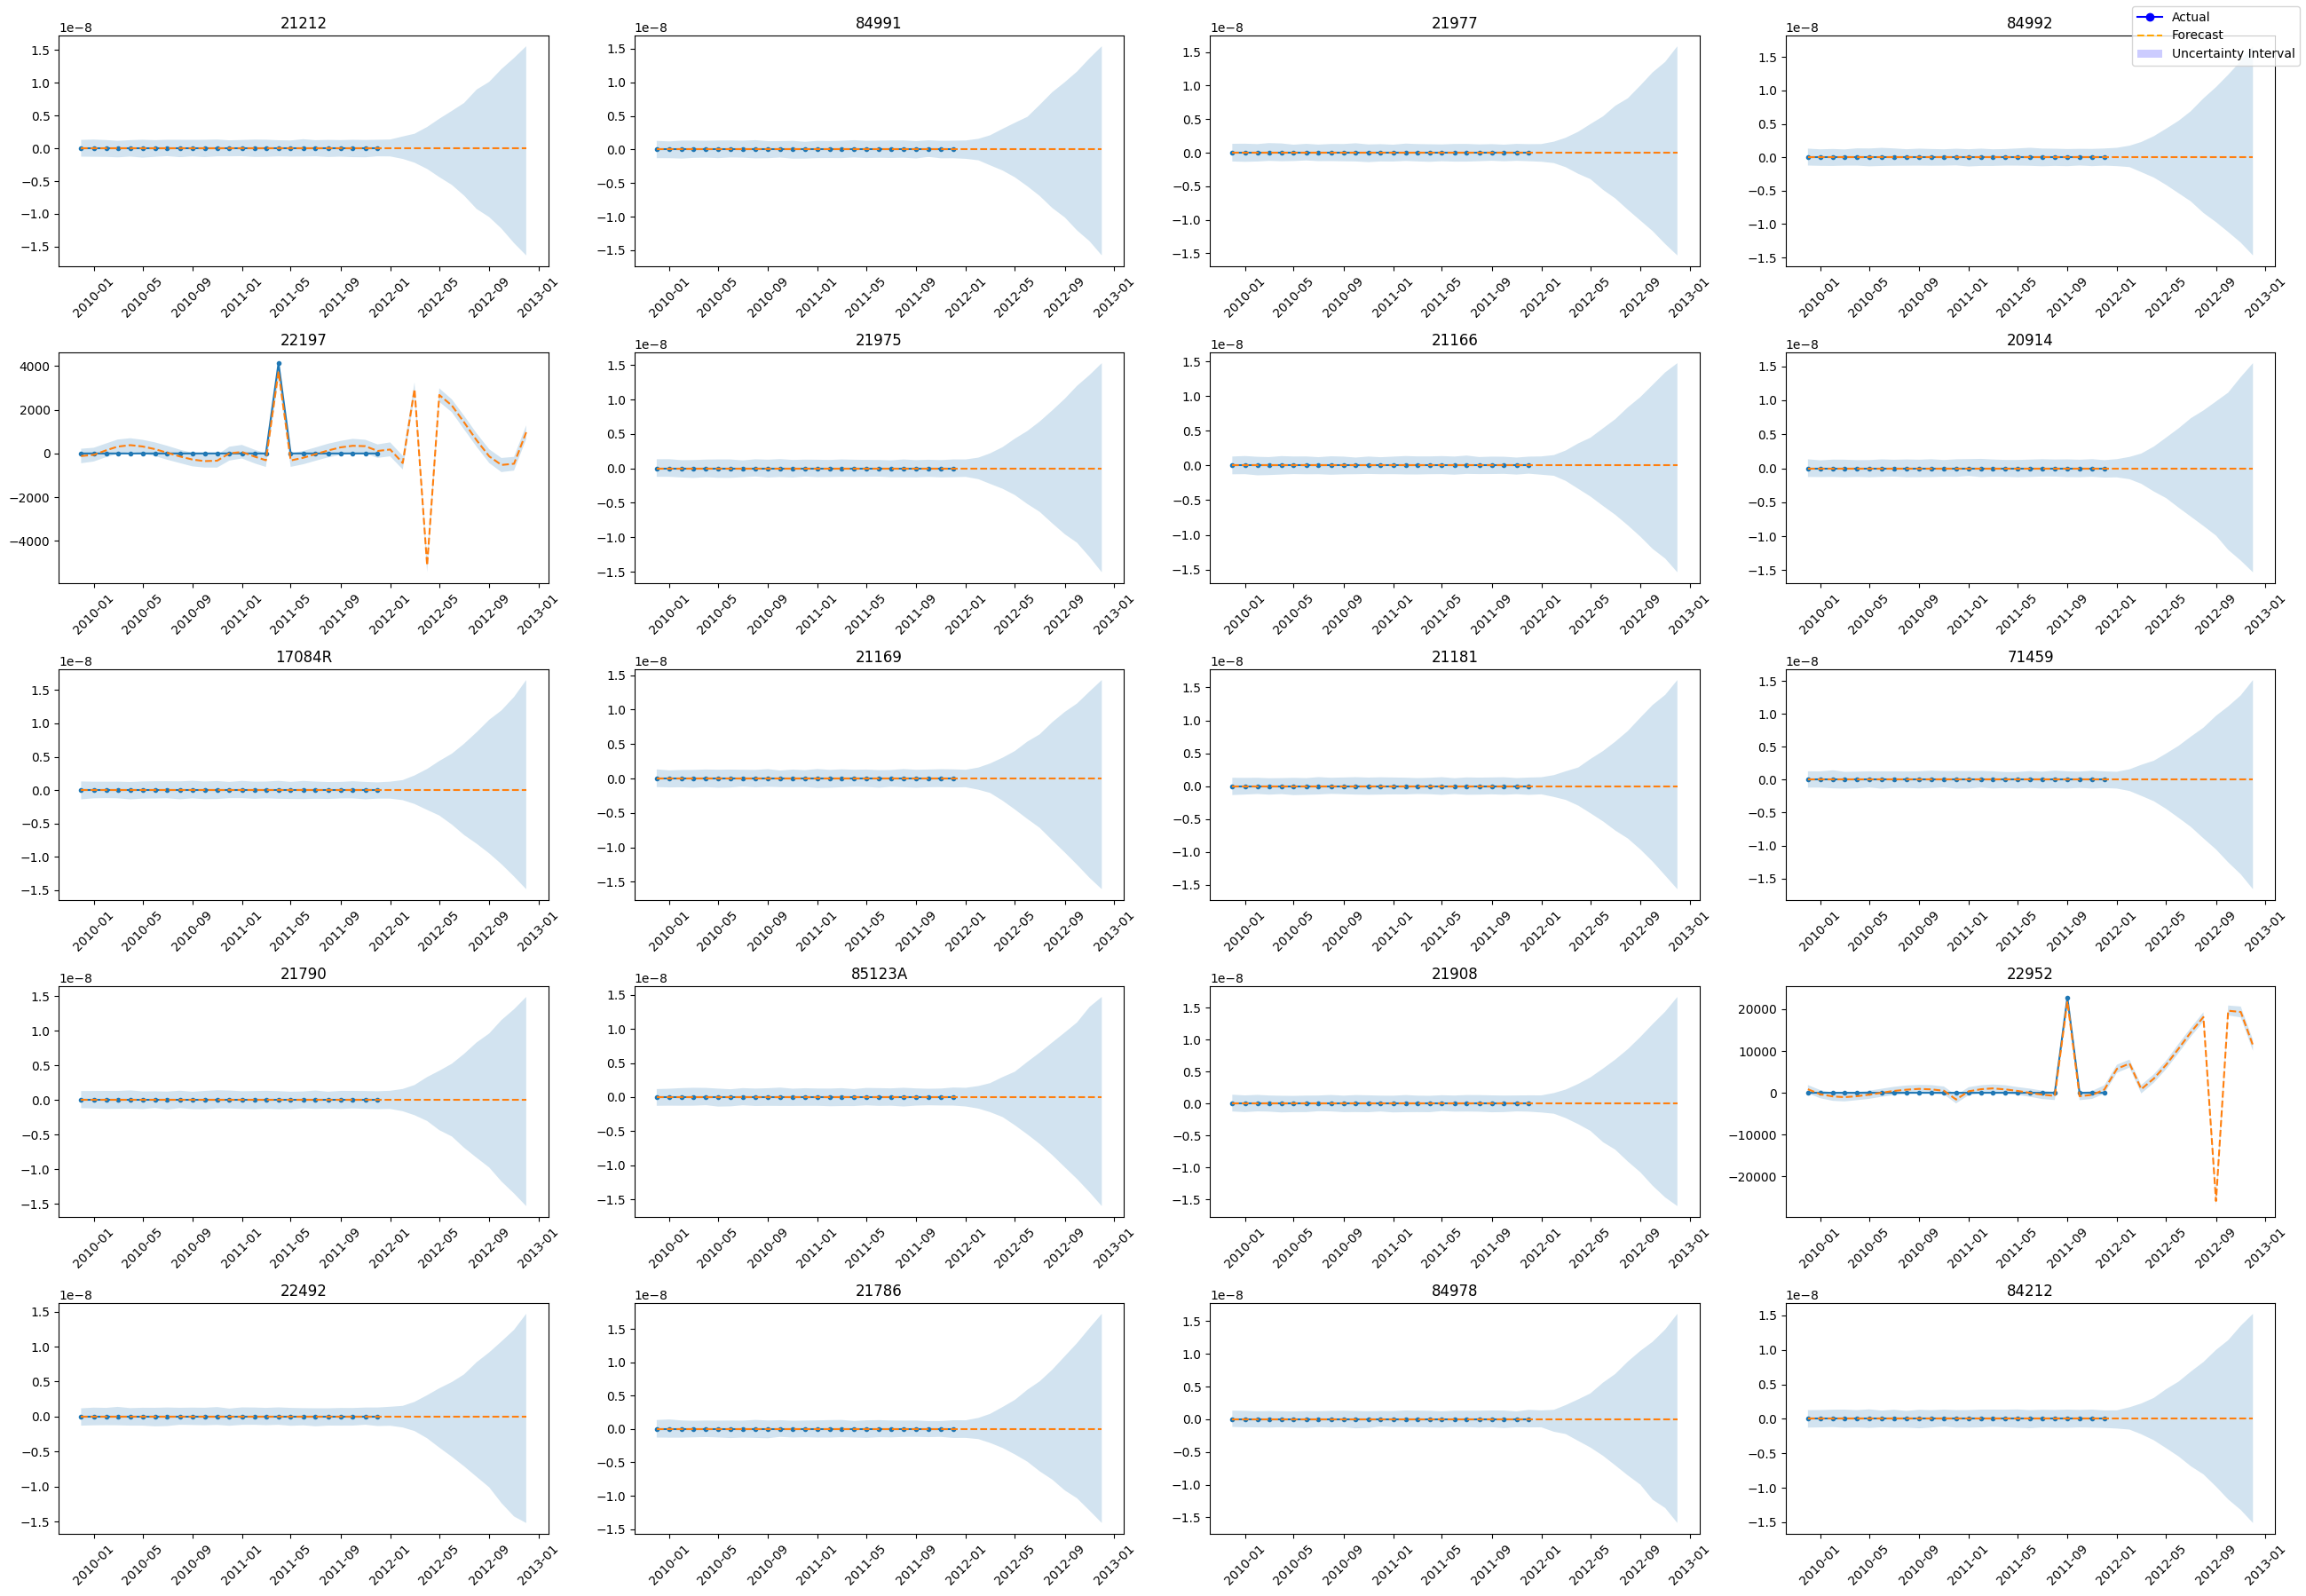

In [249]:
n = len(key_products)
rows, cols = 5, 4

fig, axes = plt.subplots(rows, cols, figsize=(26, 18))
axes = axes.flatten()

metrics = []

for ax, product_code in zip(axes, key_products):
    actual_sales = prophet_df[prophet_df['StockCode'] == product_code].copy()
    product_forecast = all_product_forecasts_df[
        all_product_forecasts_df['StockCode'] == product_code
    ].copy()

    ax.plot(
        actual_sales['ds'],
        actual_sales['y'],
        'o-',
        label='Actual',
        markersize=3,
    )
    ax.plot(
        product_forecast['ds'],
        product_forecast['yhat'],
        '--',
        label='Forecast',
    )

    ax.fill_between(
        product_forecast['ds'],
        product_forecast['yhat_lower'],
        product_forecast['yhat_upper'],
        alpha=0.2,
    )

    ax.set_title(str(product_code))
    ax.tick_params(axis='x', rotation=45)

# Hide unused plots
for ax in axes[len(key_products) :]:
    ax.axis('off')
    
legend_elements = [
    Line2D([0], [0], color='blue', marker='o', linestyle='-', label='Actual'),
    Line2D([0], [0], color='orange', linestyle='--', label='Forecast'),
    Patch(facecolor='blue', alpha=0.2, label='Uncertainty Interval'),
]

fig.legend(
    handles=legend_elements,
    loc='upper right',  # you can change this
)

plt.tight_layout()
plt.show()

# Print evaluation metrics (sorted best → worst)
if metrics:
    metrics_df = pd.DataFrame(
        metrics, columns=['StockCode', 'MAE', 'RMSE']
    ).sort_values('MAE')
    display(metrics_df)


In [250]:
monthly_sales_cost = clean_data_v2.groupby(
    ['InvoiceDate', 'StockCode'], as_index=False
)['Total Cost'].sum()

# Convert InvoiceDate to month start
monthly_sales_cost['InvoiceDate'] = (
    monthly_sales_cost['InvoiceDate'].dt.to_period('M').dt.to_timestamp()
)

# Re-group after conversion (important)
monthly_sales_cost = monthly_sales_cost.groupby(
    ['InvoiceDate', 'StockCode'], as_index=False
)['Total Cost'].sum()

monthly_sales_cost.head()


,InvoiceDate,StockCode,Total Cost
0,2009-12-01,10134,12.50
1,2009-12-01,15056BL,53.55
2,2009-12-01,15056N,17.85
3,2009-12-01,15060B,15.00
4,2009-12-01,16119,15.00


In [251]:
(
    monthly_sales_cost['InvoiceDate'].nunique(),
    monthly_sales_cost['StockCode'].nunique(),
)
monthly_sales_cost.head(10)


,InvoiceDate,StockCode,Total Cost
0,2009-12-01,10134,12.50
1,2009-12-01,15056BL,53.55
2,2009-12-01,15056N,17.85
3,2009-12-01,15060B,15.00
4,2009-12-01,16119,15.00
5,2009-12-01,17107D,15.30
6,2009-12-01,17108D,5.04
7,2009-12-01,20617,12.60
8,2009-12-01,20679,35.70
9,2009-12-01,20681,184.50


In [252]:
key_products_cost = top_20_products_cost['StockCode'].tolist()
print('Selected key products (cost):', key_products_cost)


Selected key products (cost): ['22423', '20914', '21843', '85123A', '21166', '21181', '21523', '20685', '21169', '21524', '48129', '21908', '84078A', '21164', '22838', '22960', '22138', '48184', '47566', '22197']


In [253]:
monthly_sales_cost_key = monthly_sales_cost[
    monthly_sales_cost['StockCode'].isin(key_products_cost)
].copy()

full_date_range_cost = pd.date_range(
    start=monthly_sales_cost_key['InvoiceDate'].min(),
    end=monthly_sales_cost_key['InvoiceDate'].max(),
    freq='MS',
)

full_date_range_cost[:5], full_date_range_cost[-5:]


(DatetimeIndex(['2009-12-01', '2010-01-01', '2010-02-01', '2010-03-01',
                '2010-04-01'],
               dtype='datetime64[ns]', freq='MS'),
 DatetimeIndex(['2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01',
                '2011-12-01'],
               dtype='datetime64[ns]', freq='MS'))

In [254]:
all_product_monthly_sales_cost = []

for stock_code in key_products_cost:
    product_sales = monthly_sales_cost_key[
        monthly_sales_cost_key['StockCode'] == stock_code
    ].set_index('InvoiceDate')

    if product_sales.empty:
        print('EMPTY:', stock_code)
        continue

    product_sales = product_sales.reindex(full_date_range_cost, fill_value=0)
    product_sales['StockCode'] = stock_code

    all_product_monthly_sales_cost.append(product_sales)

monthly_sales_cost_by_product = (
    pd.concat(all_product_monthly_sales_cost)
    .reset_index()
    .rename(columns={'index': 'InvoiceDate'})
)

monthly_sales_cost_by_product.head()


,InvoiceDate,StockCode,Total Cost
0,2009-12-01,22423,0.00
1,2010-01-01,22423,0.00
2,2010-02-01,22423,0.00
3,2010-03-01,22423,200.70
4,2010-04-01,22423,713.55


In [255]:
# Prophet input for Total Cost
prophet_cost_df = monthly_sales_cost_by_product.rename(
    columns={'InvoiceDate': 'ds', 'Total Cost': 'y'}
).copy()

prophet_cost_df['ds'] = pd.to_datetime(prophet_cost_df['ds'])

unique_stock_codes = prophet_cost_df['StockCode'].unique()

all_product_forecasts_cost = []

for stock_code in unique_stock_codes:
    product_data = prophet_cost_df[
        prophet_cost_df['StockCode'] == stock_code
    ].copy()
    product_data = product_data.sort_values('ds')

    # Prophet requires at least two data points to fit
    if len(product_data) < 2:
        continue

    # Initialize Prophet model, adding yearly seasonality
    model = Prophet(yearly_seasonality=True)

    # Fit the model to the product's historical data
    model.fit(product_data[['ds', 'y']])

    # Create a future DataFrame for the next 12 months (2012)
    future = model.make_future_dataframe(periods=12, freq='MS')

    # Generate predictions
    forecast = model.predict(future)

    # Add the StockCode to the forecast for identification
    forecast['StockCode'] = stock_code

    # Append the forecast to the list
    all_product_forecasts_cost.append(forecast)

# Concatenate all individual product forecasts into a single DataFrame
all_product_forecasts_cost_df = pd.concat(
    all_product_forecasts_cost, ignore_index=True
)

print('Forecasts generated for all products (Total Cost).')
all_product_forecasts_cost_df.head()


17:57:52 - cmdstanpy - INFO - Chain [1] start processing
17:57:52 - cmdstanpy - INFO - Chain [1] done processing
17:57:52 - cmdstanpy - INFO - Chain [1] start processing
17:58:03 - cmdstanpy - INFO - Chain [1] done processing
17:58:03 - cmdstanpy - INFO - Chain [1] start processing
17:58:03 - cmdstanpy - INFO - Chain [1] done processing
17:58:03 - cmdstanpy - INFO - Chain [1] start processing
17:58:03 - cmdstanpy - INFO - Chain [1] done processing
17:58:03 - cmdstanpy - INFO - Chain [1] start processing
17:58:03 - cmdstanpy - INFO - Chain [1] done processing
17:58:03 - cmdstanpy - INFO - Chain [1] start processing
17:58:03 - cmdstanpy - INFO - Chain [1] done processing
17:58:04 - cmdstanpy - INFO - Chain [1] start processing
17:58:04 - cmdstanpy - INFO - Chain [1] done processing
17:58:04 - cmdstanpy - INFO - Chain [1] start processing
17:58:04 - cmdstanpy - INFO - Chain [1] done processing
17:58:04 - cmdstanpy - INFO - Chain [1] start processing
17:58:04 - cmdstanpy - INFO - Chain [1]

Forecasts generated for all products (Total Cost).


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,StockCode
0,2009-12-01,902.415272,-16.989330,425.905938,902.415272,902.415272,-697.556562,-697.556562,-697.556562,-697.556562,-697.556562,-697.556562,0.0,0.0,0.0,204.858710,22423
1,2010-01-01,899.438342,-15.067448,432.982658,899.438342,899.438342,-683.321032,-683.321032,-683.321032,-683.321032,-683.321032,-683.321032,0.0,0.0,0.0,216.117310,22423
2,2010-02-01,896.461412,29.796098,476.782770,896.461412,896.461412,-639.695886,-639.695886,-639.695886,-639.695886,-639.695886,-639.695886,0.0,0.0,0.0,256.765527,22423
3,2010-03-01,893.772572,179.630717,630.950420,893.772572,893.772572,-483.217831,-483.217831,-483.217831,-483.217831,-483.217831,-483.217831,0.0,0.0,0.0,410.554741,22423
4,2010-04-01,890.795642,564.548500,1001.758218,890.795642,890.795642,-97.953216,-97.953216,-97.953216,-97.953216,-97.953216,-97.953216,0.0,0.0,0.0,792.842426,22423


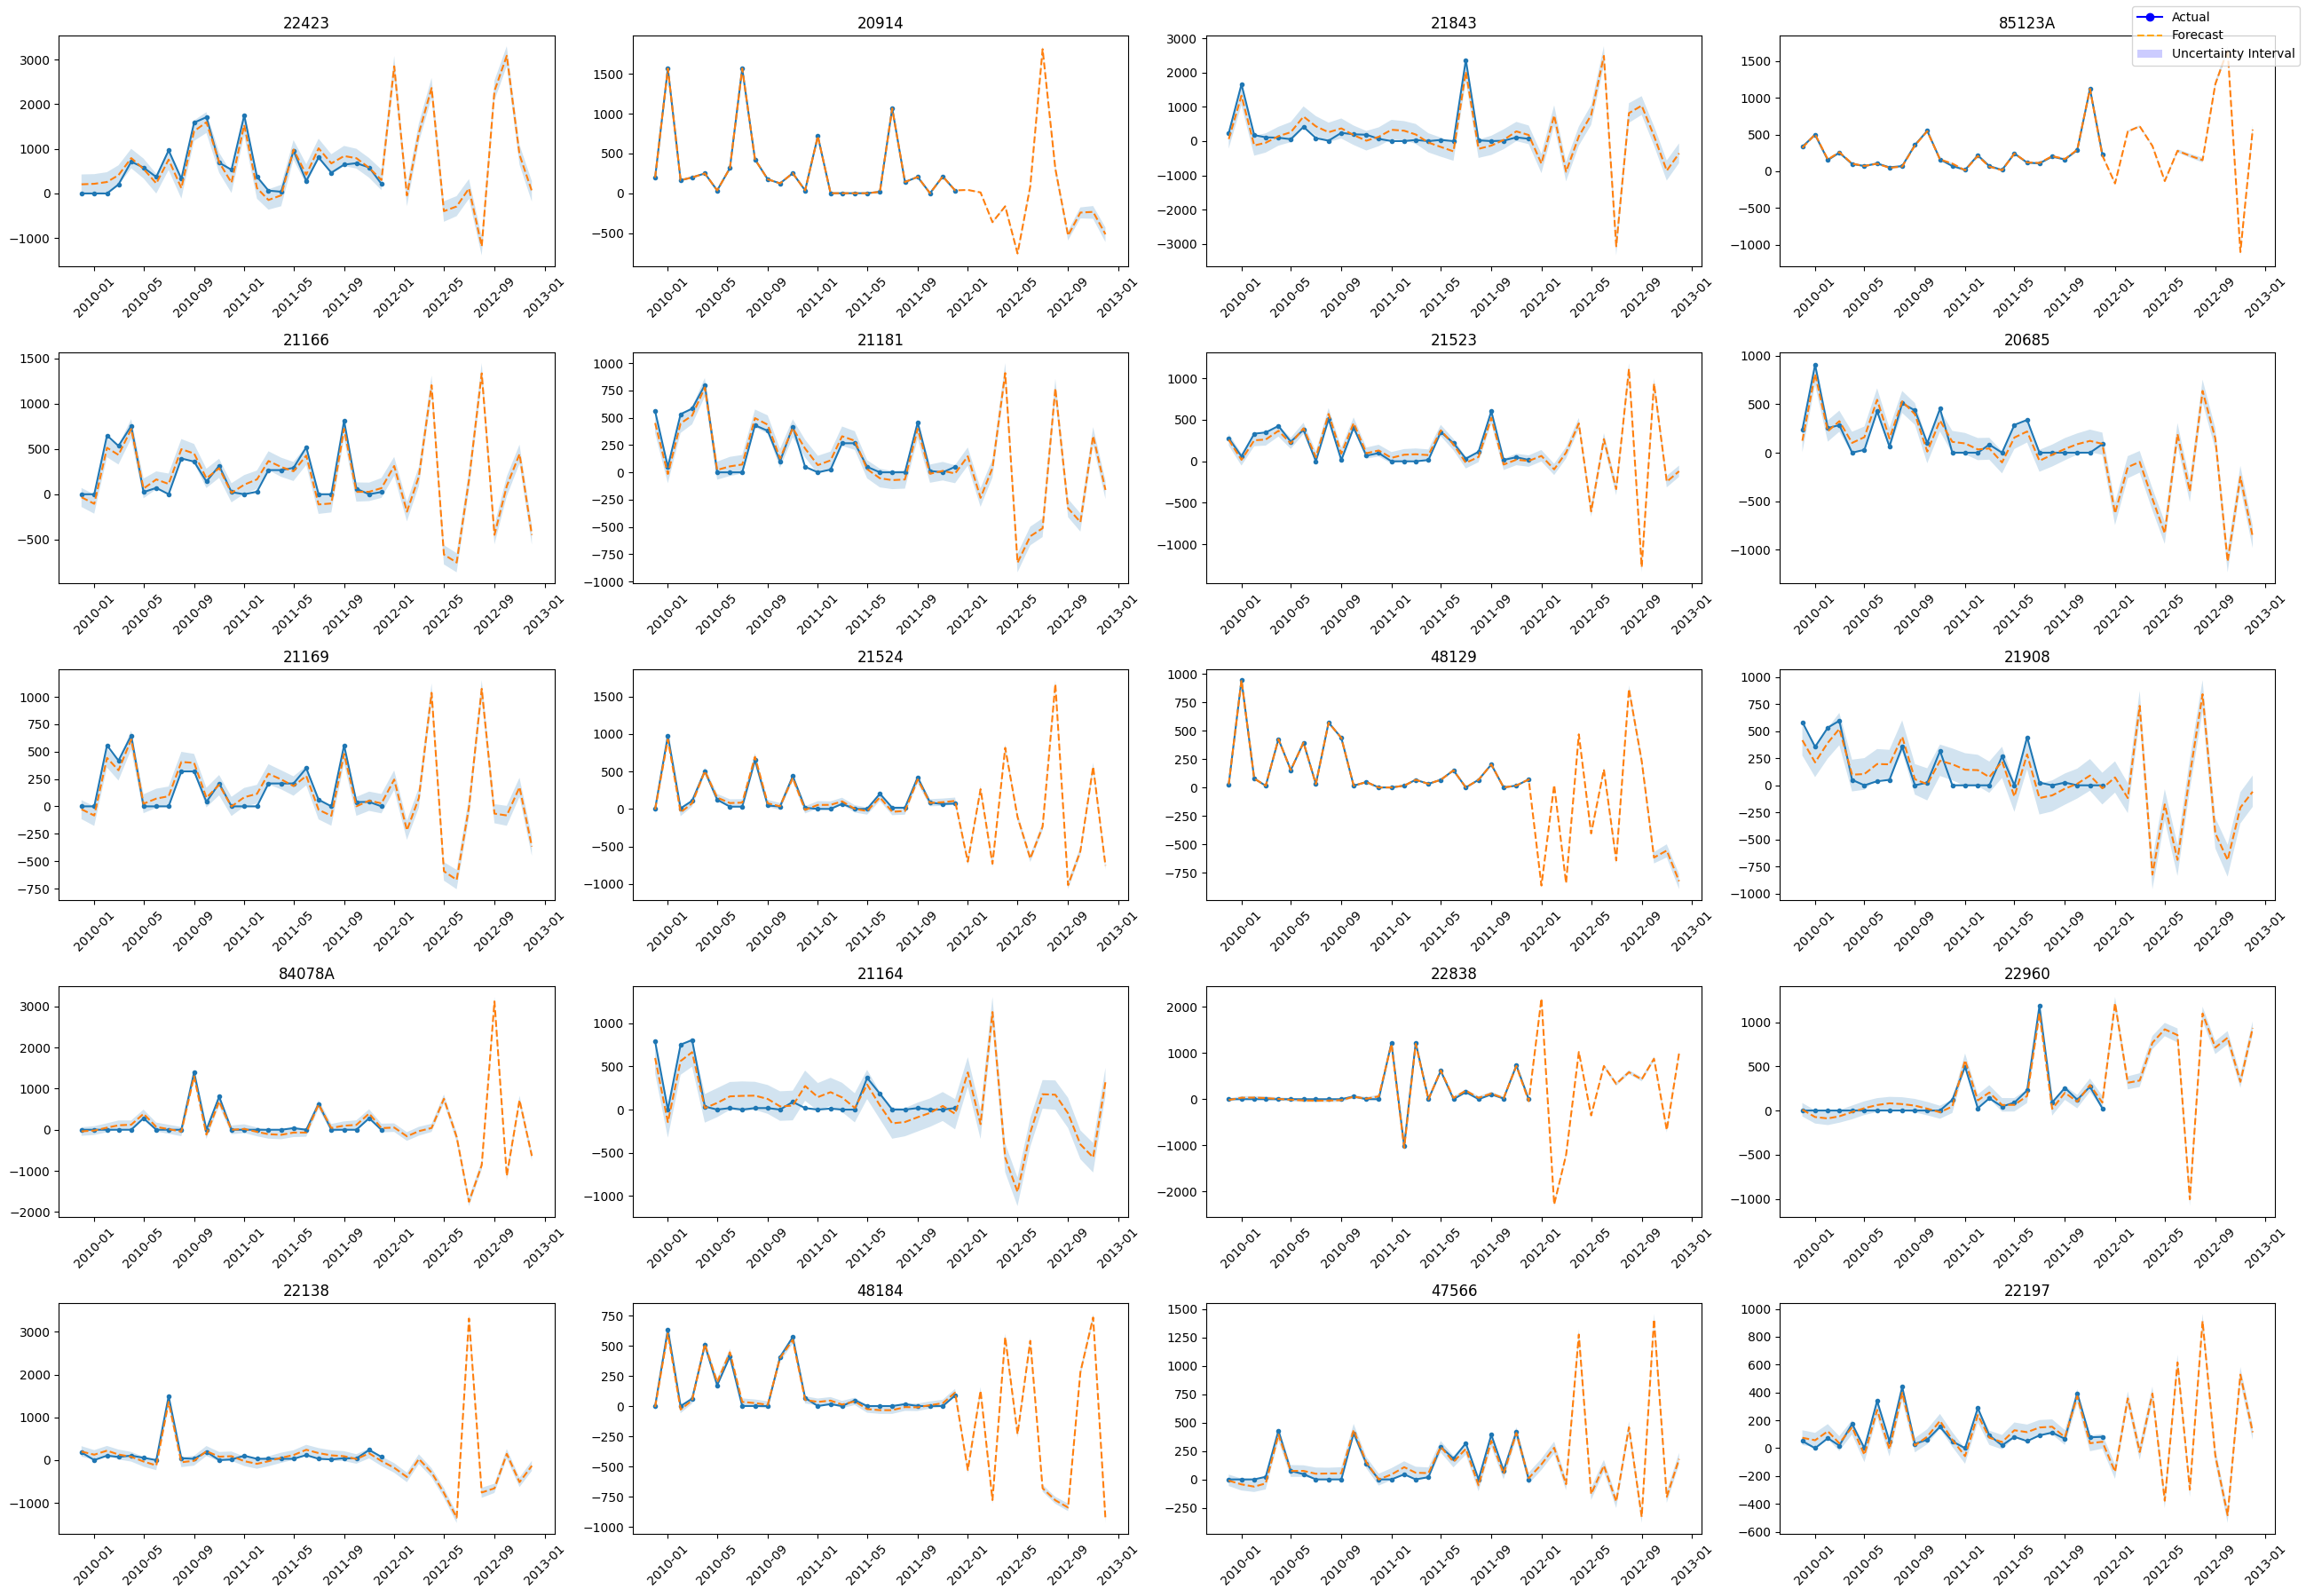

In [257]:
key_products = key_products_cost  # top 20 cost products

n = len(key_products)
rows, cols = 5, 4

fig, axes = plt.subplots(rows, cols, figsize=(26, 18))
axes = axes.flatten()

metrics = []

for ax, product_code in zip(axes, key_products):
    actual_sales = prophet_cost_df[
        prophet_cost_df['StockCode'] == product_code
    ].copy()
    product_forecast = all_product_forecasts_cost_df[
        all_product_forecasts_cost_df['StockCode'] == product_code
    ].copy()

    # Ensure sorted for clean plotting
    actual_sales = actual_sales.sort_values('ds')
    product_forecast = product_forecast.sort_values('ds')

    ax.plot(
        actual_sales['ds'],
        actual_sales['y'],
        'o-',
        label='Actual',
        markersize=3,
    )
    ax.plot(
        product_forecast['ds'],
        product_forecast['yhat'],
        '--',
        label='Forecast',
    )

    ax.fill_between(
        product_forecast['ds'],
        product_forecast['yhat_lower'],
        product_forecast['yhat_upper'],
        alpha=0.2,
    )

    ax.set_title(str(product_code))
    ax.tick_params(axis='x', rotation=45)

# Hide unused plots
for ax in axes[len(key_products) :]:
    ax.axis('off')

legend_elements = [
    Line2D([0], [0], color='blue', marker='o', linestyle='-', label='Actual'),
    Line2D([0], [0], color='orange', linestyle='--', label='Forecast'),
    Patch(facecolor='blue', alpha=0.2, label='Uncertainty Interval'),
]

fig.legend(
    handles=legend_elements,
    loc='upper right',  # you can change this
)

plt.tight_layout()
plt.show()
